# Tweet Sentiment's Impact on Stock Returns 
## 22BDS0285

### Import Libraries and Setup

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For text processing and sentiment analysis
import re
from textstat import flesch_reading_ease
from datetime import datetime, timedelta

# For machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, 
                            accuracy_score, classification_report, confusion_matrix, 
                            roc_auc_score, precision_recall_curve)

# For visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For statistical analysis
from scipy.stats import pearsonr, spearmanr, normaltest, jarque_bera
from scipy import stats

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

### Load and Initial Data Exploration

In [ ]:
df = pd.read_csv("full_dataset-release.csv")

In [10]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (1395450, 14)

Column Names: ['Unnamed: 0', 'TWEET', 'STOCK', 'DATE', 'LAST_PRICE', '1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN', 'PX_VOLUME', 'VOLATILITY_10D', 'VOLATILITY_30D', 'LSTM_POLARITY', 'TEXTBLOB_POLARITY']

First 5 rows:
  Unnamed: 0                                              TWEET       STOCK  \
0          0  RT @robertoglezcano: @amazon  #Patents Show Fl...         NaN   
1        NaN                                             Amazon  31/01/2017   
2          1  @FAME95FM1 Jamaicans make money with @Payoneer...      PayPal   
3          2  @CBSi Jamaicans make money with @Payoneer @Pay...      PayPal   
4          3  @Hitz92fm Jamaicans make money with @Payoneer ...      PayPal   

         DATE  LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  \
0         NaN         NaN           NaN           NaN           NaN   
1      823.48    0.008379      0.014924      0.014924     -0.001263   
2  31/01/2017   39.780000      0.002011      0.

In [12]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395450 entries, 0 to 1395449
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1102013 non-null  object 
 1   TWEET              1395398 non-null  object 
 2   STOCK              862231 non-null   object 
 3   DATE               862231 non-null   object 
 4   LAST_PRICE         862231 non-null   float64
 5   1_DAY_RETURN       862231 non-null   float64
 6   2_DAY_RETURN       862231 non-null   float64
 7   3_DAY_RETURN       862231 non-null   float64
 8   7_DAY_RETURN       862231 non-null   float64
 9   PX_VOLUME          862231 non-null   float64
 10  VOLATILITY_10D     862130 non-null   float64
 11  VOLATILITY_30D     862184 non-null   float64
 12  LSTM_POLARITY      661102 non-null   float64
 13  TEXTBLOB_POLARITY  367665 non-null   float64
dtypes: float64(10), object(4)
memory usage: 149.1+ MB
None


In [13]:
print("\nMissing Values:")
missing_summary = df.isnull().sum()
print(missing_summary)


Missing Values:
Unnamed: 0            293437
TWEET                     52
STOCK                 533219
DATE                  533219
LAST_PRICE            533219
1_DAY_RETURN          533219
2_DAY_RETURN          533219
3_DAY_RETURN          533219
7_DAY_RETURN          533219
PX_VOLUME             533219
VOLATILITY_10D        533320
VOLATILITY_30D        533266
LSTM_POLARITY         734348
TEXTBLOB_POLARITY    1027785
dtype: int64


In [14]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
          LAST_PRICE   1_DAY_RETURN   2_DAY_RETURN  3_DAY_RETURN  \
count  862231.000000  862231.000000  862231.000000  8.622310e+05   
mean      716.123477       0.001473       0.002579  3.262616e+06   
std      4731.498118       0.023068       0.032594  1.053913e+07   
min        -0.173554      -0.177851      -0.204959 -2.049587e-01   
25%         0.000000      -0.007511      -0.011456 -8.465608e-03   
50%         0.014220       0.000000       0.000000  1.019542e-02   
75%       115.600000       0.008192       0.013911  6.545426e-02   
max    165500.000000       0.243639       0.267113  3.081068e+08   

       7_DAY_RETURN     PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  \
count  8.622310e+05  8.622310e+05   862130.000000   862184.000000   
mean   6.201036e+06  7.522187e+06       18.293836       10.738204   
std    1.388221e+07  1.591847e+07       16.277630       14.693986   
min   -2.049587e-01  1.000000e+00       -1.000000       -1.000000   
25%    5.474453e-03  2.

#### Check unique Stocks

In [19]:
print(f"\nUnique Stocks ({df['STOCK'].nunique()}): ")
print(df['STOCK'].value_counts().head(10))


Unique Stocks (4241): 
STOCK
Ford          52198
Facebook      40837
Google        33697
Next          32606
Apple         27940
Nike          27268
Amazon        23994
Netflix       18516
Disney        13728
04/09/2018    10123
Name: count, dtype: int64


#### Check data types

In [22]:
print("\nData Types:")
print(df.dtypes)



Data Types:
Unnamed: 0            object
TWEET                 object
STOCK                 object
DATE                  object
LAST_PRICE           float64
1_DAY_RETURN         float64
2_DAY_RETURN         float64
3_DAY_RETURN         float64
7_DAY_RETURN         float64
PX_VOLUME            float64
VOLATILITY_10D       float64
VOLATILITY_30D       float64
LSTM_POLARITY        float64
TEXTBLOB_POLARITY    float64
dtype: object


### Data Cleaning and Preprocessing

#### Handle the DATE column properly

In [25]:
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")

Date range: 1703-05-01 00:00:00 to 2248-05-01 00:00:00


#### Remove rows with missing critical information

In [33]:
print(f"Original dataset size: {df.shape[0]}")

Original dataset size: 862231


#### Remove rows where STOCK is NaN or empty

In [35]:
df = df.dropna(subset=['STOCK'])
print(f"After removing rows without stock info: {df.shape[0]}")

After removing rows without stock info: 862231


#### Remove rows where both sentiment measures are NaN

In [37]:
df = df.dropna(subset=['LSTM_POLARITY', 'TEXTBLOB_POLARITY'], how='all')
print(f"After removing rows without sentiment data: {df.shape[0]}")

After removing rows without sentiment data: 661102


#### Handle missing values in numerical columns

In [39]:
numerical_cols = ['LAST_PRICE', '1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', 
                 '7_DAY_RETURN', 'PX_VOLUME', 'VOLATILITY_10D', 'VOLATILITY_30D']

#### Check for infinite values

In [41]:
for col in numerical_cols:
    if col in df.columns:
        inf_count = np.isinf(df[col]).sum()
        if inf_count > 0:
            print(f"Found {inf_count} infinite values in {col}")
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)

#### Fill missing values with group-wise median (by stock)

In [43]:
for col in numerical_cols:
    if col in df.columns:
        df[col] = df.groupby('STOCK')[col].transform(lambda x: x.fillna(x.median()))
        # If still NaN (entire stock group is NaN), fill with overall median
        df[col] = df[col].fillna(df[col].median())

#### Handle sentiment columns

In [46]:
for col in ['LSTM_POLARITY', 'TEXTBLOB_POLARITY']:
    if col in df.columns:
        df[col] = df[col].fillna(0) 

#### Outlier Detection and Treatment

In [50]:
def detect_outliers_iqr(data, multiplier=2.5):
    """Detect outliers using IQR method with adjustable multiplier"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (data < lower_bound) | (data > upper_bound)

outlier_cols = ['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']

In [54]:
print("\nOutlier Detection and Treatment:")
for col in outlier_cols:
    if col in df.columns:
        outliers = detect_outliers_iqr(df[col], multiplier=3.0)  
        outlier_count = outliers.sum()
        print(f"{col}: {outlier_count} outliers detected ({outlier_count/len(df)*100:.2f}%)")
        
        # Cap outliers instead of removing them
        Q1 = df[col].quantile(0.01)  
        Q99 = df[col].quantile(0.99)  
        df[col] = df[col].clip(lower=Q1, upper=Q99)


Outlier Detection and Treatment:
1_DAY_RETURN: 16682 outliers detected (2.52%)
2_DAY_RETURN: 5825 outliers detected (0.88%)
3_DAY_RETURN: 3773 outliers detected (0.57%)
7_DAY_RETURN: 45504 outliers detected (6.88%)


In [55]:
print(f"Final dataset shape: {df.shape}")

Final dataset shape: (661102, 14)


### Feature Engineering

#### Date based Features

In [60]:
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df['weekday'] = df['DATE'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['quarter'] = df['DATE'].dt.quarter

#### Sentiment features

In [63]:
df['sentiment_avg'] = (df['LSTM_POLARITY'] + df['TEXTBLOB_POLARITY']) / 2
df['sentiment_diff'] = df['LSTM_POLARITY'] - df['TEXTBLOB_POLARITY']
df['sentiment_abs_avg'] = (abs(df['LSTM_POLARITY']) + abs(df['TEXTBLOB_POLARITY'])) / 2
df['sentiment_consensus'] = ((df['LSTM_POLARITY'] > 0) & (df['TEXTBLOB_POLARITY'] > 0)).astype(int)

#### Price and volume features

In [65]:
df['price_log'] = np.log1p(df['LAST_PRICE'])
df['volume_log'] = np.log1p(df['PX_VOLUME'])
df['volatility_ratio'] = df['VOLATILITY_10D'] / (df['VOLATILITY_30D'] + 1e-8)

#### Return volatility

In [67]:
return_cols = ['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN']
df['return_volatility'] = df[return_cols].std(axis=1, skipna=True)

#### Stock-specific encoding

In [69]:
le_stock = LabelEncoder()
df['stock_encoded'] = le_stock.fit_transform(df['STOCK'])

#### Target variables for classification (direction prediction)

In [71]:
df['return_direction_1d'] = (df['1_DAY_RETURN'] > 0).astype(int)
df['return_direction_3d'] = (df['3_DAY_RETURN'] > 0).astype(int)
df['return_direction_7d'] = (df['7_DAY_RETURN'] > 0).astype(int)

### Univariate Analysis

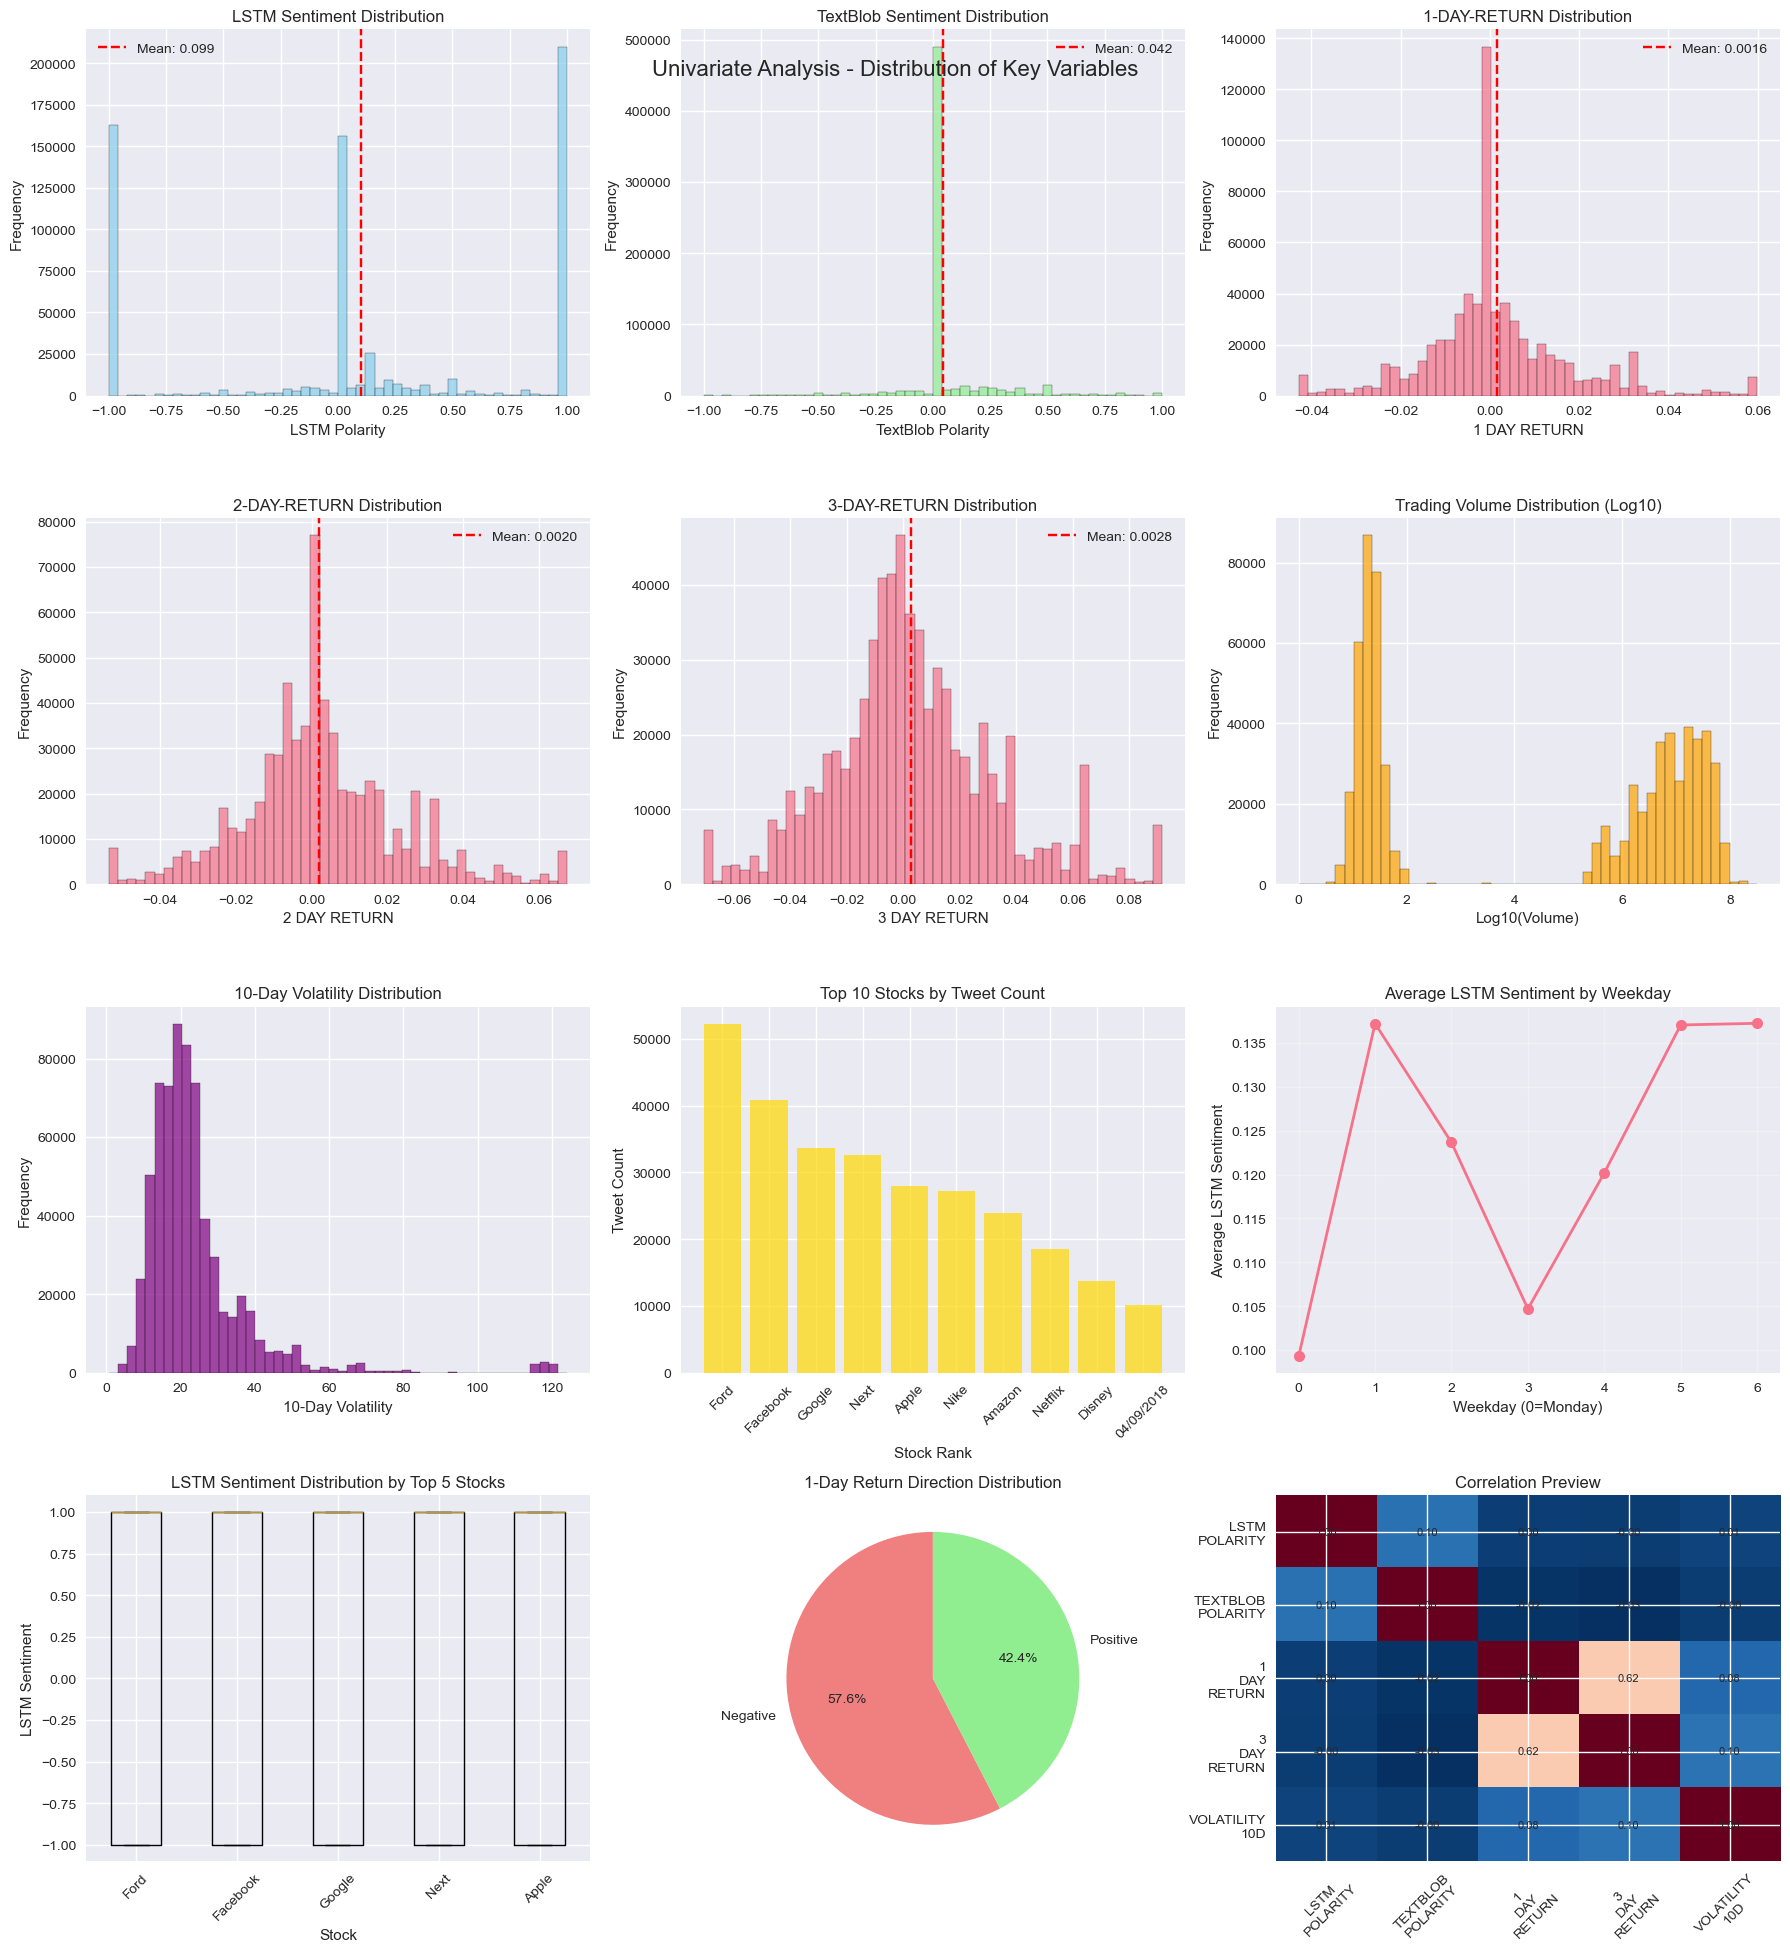

In [115]:
# Create figure for univariate analysis
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Univariate Analysis - Distribution of Key Variables', fontsize=16, y=0.95)

# 1. Sentiment distributions
axes[0,0].hist(df['LSTM_POLARITY'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('LSTM Sentiment Distribution')
axes[0,0].set_xlabel('LSTM Polarity')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df['LSTM_POLARITY'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {df["LSTM_POLARITY"].mean():.3f}')
axes[0,0].legend()

axes[0,1].hist(df['TEXTBLOB_POLARITY'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('TextBlob Sentiment Distribution')
axes[0,1].set_xlabel('TextBlob Polarity')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(df['TEXTBLOB_POLARITY'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {df["TEXTBLOB_POLARITY"].mean():.3f}')
axes[0,1].legend()

# 2. Return distributions
for i, return_col in enumerate(['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN']):
    row, col = (0, 2) if i == 0 else (1, i-1)
    axes[row, col].hist(df[return_col], bins=50, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{return_col.replace("_", "-")} Distribution')
    axes[row, col].set_xlabel(return_col.replace('_', ' '))
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].axvline(df[return_col].mean(), color='red', linestyle='--', 
                          label=f'Mean: {df[return_col].mean():.4f}')
    axes[row, col].legend()

# 3. Volume and price distributions
axes[1,2].hist(np.log10(df['PX_VOLUME']), bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,2].set_title('Trading Volume Distribution (Log10)')
axes[1,2].set_xlabel('Log10(Volume)')
axes[1,2].set_ylabel('Frequency')

axes[2,0].hist(df['VOLATILITY_10D'], bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[2,0].set_title('10-Day Volatility Distribution')
axes[2,0].set_xlabel('10-Day Volatility')
axes[2,0].set_ylabel('Frequency')

# 4. Top stocks by tweet count
top_stocks = df['STOCK'].value_counts().head(10)
axes[2,1].bar(range(len(top_stocks)), top_stocks.values, alpha=0.7, color='gold')
axes[2,1].set_title('Top 10 Stocks by Tweet Count')
axes[2,1].set_xlabel('Stock Rank')
axes[2,1].set_ylabel('Tweet Count')
axes[2,1].set_xticks(range(len(top_stocks)))
axes[2,1].set_xticklabels(top_stocks.index, rotation=45)

# 5. Sentiment by weekday
weekday_sentiment = df.groupby('weekday')['LSTM_POLARITY'].mean()
axes[2,2].plot(weekday_sentiment.index, weekday_sentiment.values, marker='o', linewidth=2, markersize=8)
axes[2,2].set_title('Average LSTM Sentiment by Weekday')
axes[2,2].set_xlabel('Weekday (0=Monday)')
axes[2,2].set_ylabel('Average LSTM Sentiment')
axes[2,2].grid(True, alpha=0.3)

# 6. Box plots for sentiment by stock (top 5)
top_5_stocks = df['STOCK'].value_counts().head(5).index
df_top5 = df[df['STOCK'].isin(top_5_stocks)]
axes[3,0].boxplot([df_top5[df_top5['STOCK'] == stock]['LSTM_POLARITY'].values 
                   for stock in top_5_stocks], labels=top_5_stocks)
axes[3,0].set_title('LSTM Sentiment Distribution by Top 5 Stocks')
axes[3,0].set_xlabel('Stock')
axes[3,0].set_ylabel('LSTM Sentiment')
axes[3,0].tick_params(axis='x', rotation=45)

# 7. Return direction distribution
return_directions = df['return_direction_1d'].value_counts()
axes[3,1].pie(return_directions.values, labels=['Negative', 'Positive'], autopct='%1.1f%%', 
              colors=['lightcoral', 'lightgreen'], startangle=90)
axes[3,1].set_title('1-Day Return Direction Distribution')

# 8. Correlation heatmap preview
correlation_vars = ['LSTM_POLARITY', 'TEXTBLOB_POLARITY', '1_DAY_RETURN', '3_DAY_RETURN', 'VOLATILITY_10D']
corr_matrix_preview = df[correlation_vars].corr()
im = axes[3,2].imshow(corr_matrix_preview, cmap='RdBu_r', aspect='auto')
axes[3,2].set_title('Correlation Preview')
axes[3,2].set_xticks(range(len(correlation_vars)))
axes[3,2].set_yticks(range(len(correlation_vars)))
axes[3,2].set_xticklabels([var.replace('_', '\n') for var in correlation_vars], rotation=45)
axes[3,2].set_yticklabels([var.replace('_', '\n') for var in correlation_vars])

# Add correlation values
for i in range(len(correlation_vars)):
    for j in range(len(correlation_vars)):
        axes[3,2].text(j, i, f'{corr_matrix_preview.iloc[i, j]:.2f}', 
                      ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

#### Summary Statistics

In [107]:
print("\n UNIVARIATE ANALYSIS SUMMARY")
print("="*50)

print("\n1. Sentiment Statistics:")
print(f"LSTM Polarity - Mean: {df['LSTM_POLARITY'].mean():.4f}, Std: {df['LSTM_POLARITY'].std():.4f}")
print(f"TextBlob Polarity - Mean: {df['TEXTBLOB_POLARITY'].mean():.4f}, Std: {df['TEXTBLOB_POLARITY'].std():.4f}")

print("\n2. Return Statistics:")
for col in ['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']:
    if col in df.columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        print(f"{col} - Mean: {mean_val:.6f}, Std: {std_val:.6f}")

print("\n3. Market Statistics:")
print(f"Average Volume: {df['PX_VOLUME'].mean():,.0f}")
print(f"Average 10-Day Volatility: {df['VOLATILITY_10D'].mean():.2f}")

print(f"\n4. Dataset Coverage:")
print(f"Number of unique stocks: {df['STOCK'].nunique()}")
print(f"Date range: {df['DATE'].min().strftime('%Y-%m-%d')} to {df['DATE'].max().strftime('%Y-%m-%d')}")
print(f"Total observations: {len(df):,}")


 UNIVARIATE ANALYSIS SUMMARY

1. Sentiment Statistics:
LSTM Polarity - Mean: 0.0994, Std: 0.7605
TextBlob Polarity - Mean: 0.0424, Std: 0.1983

2. Return Statistics:
1_DAY_RETURN - Mean: 0.001592, Std: 0.016358
2_DAY_RETURN - Mean: 0.001957, Std: 0.020693
3_DAY_RETURN - Mean: 0.002836, Std: 0.029203
7_DAY_RETURN - Mean: 8015425.221257, Std: 14984873.957505

3. Market Statistics:
Average Volume: 9,810,675
Average 10-Day Volatility: 23.82

4. Dataset Coverage:
Number of unique stocks: 170
Date range: 1703-05-01 to 2248-05-01
Total observations: 661,102


### Bivariate Analysis

#### Comprehensive correlation matrix

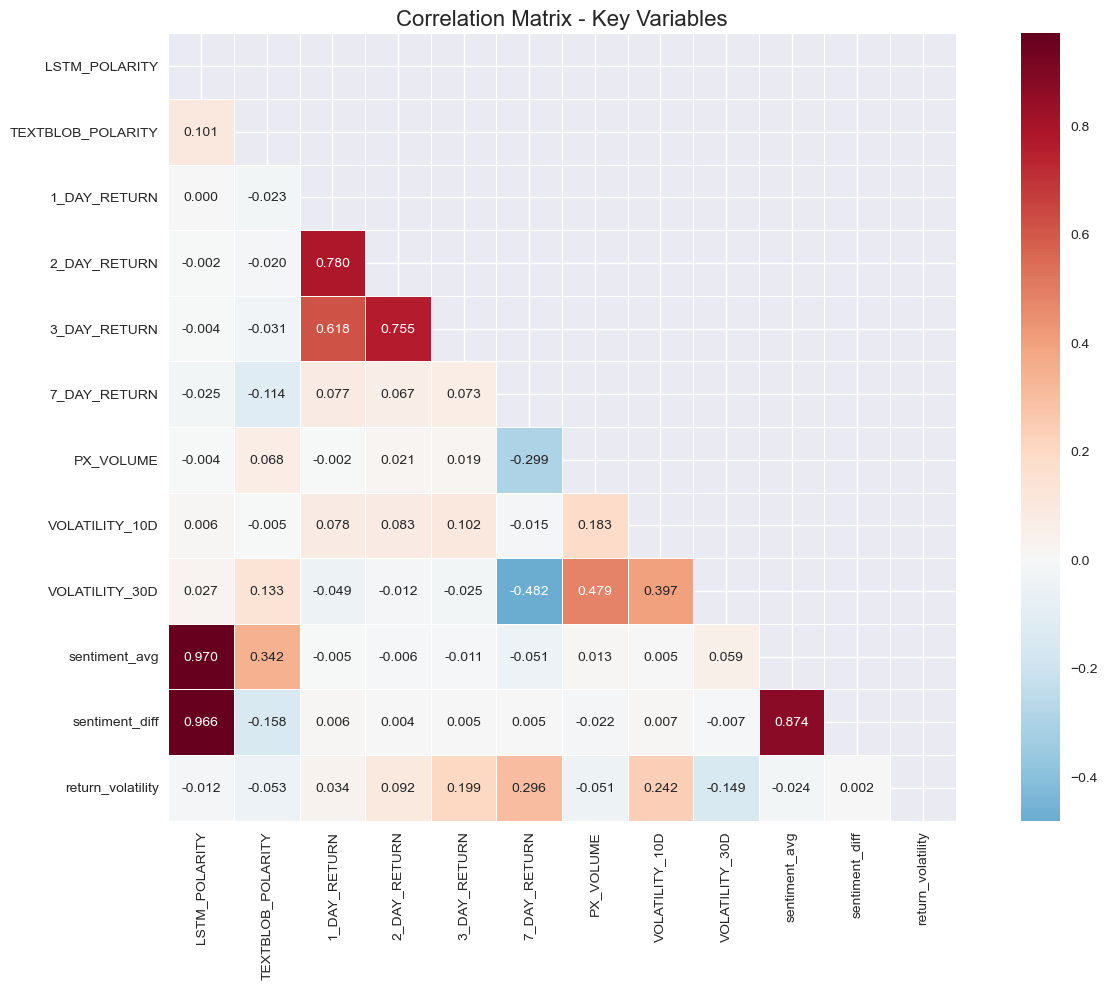

In [118]:
correlation_cols = ['LSTM_POLARITY', 'TEXTBLOB_POLARITY', '1_DAY_RETURN', '2_DAY_RETURN', 
                   '3_DAY_RETURN', '7_DAY_RETURN', 'PX_VOLUME', 'VOLATILITY_10D', 
                   'VOLATILITY_30D', 'sentiment_avg', 'sentiment_diff', 'return_volatility']

# Calculate correlation matrix
correlation_matrix = df[correlation_cols].corr()

# Create heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, fmt='.3f', mask=mask)
plt.title('Correlation Matrix - Key Variables', fontsize=16)
plt.tight_layout()
plt.show()

#### Scatter plots for key relationships

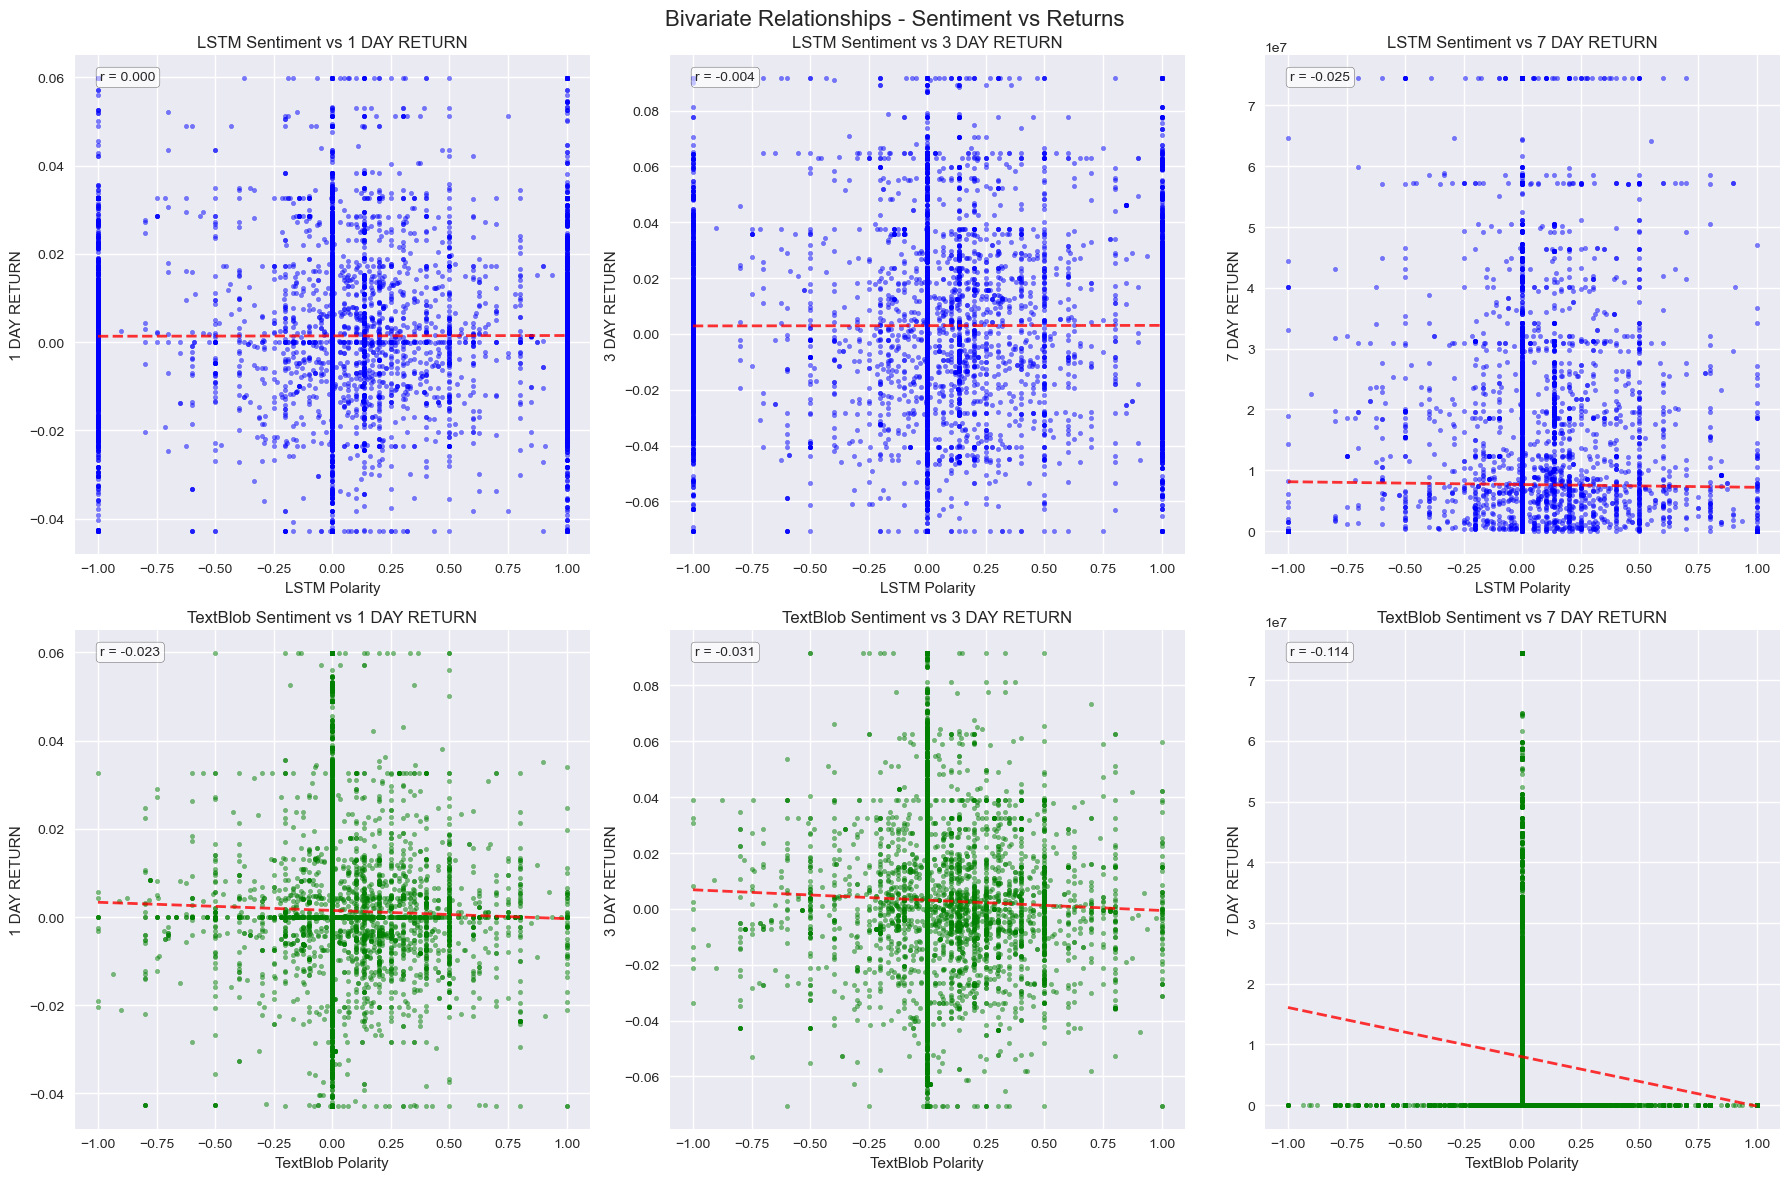

In [121]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Bivariate Relationships - Sentiment vs Returns', fontsize=16)

# Sample data for performance
sample_size = min(10000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

# LSTM sentiment vs returns
for i, return_col in enumerate(['1_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']):
    row, col = (0, i)
    
    axes[row, col].scatter(df_sample['LSTM_POLARITY'], df_sample[return_col], 
                          alpha=0.5, s=10, color='blue')
    axes[row, col].set_xlabel('LSTM Polarity')
    axes[row, col].set_ylabel(return_col.replace('_', ' '))
    axes[row, col].set_title(f'LSTM Sentiment vs {return_col.replace("_", " ")}')
    
    # Add trend line
    z = np.polyfit(df_sample['LSTM_POLARITY'], df_sample[return_col], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_sample['LSTM_POLARITY'].min(), df_sample['LSTM_POLARITY'].max(), 100)
    axes[row, col].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
    
    # Add correlation coefficient
    corr_coef = df['LSTM_POLARITY'].corr(df[return_col])
    axes[row, col].text(0.05, 0.95, f'r = {corr_coef:.3f}', 
                       transform=axes[row, col].transAxes, fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# TextBlob sentiment vs returns
for i, return_col in enumerate(['1_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']):
    row, col = (1, i)
    
    axes[row, col].scatter(df_sample['TEXTBLOB_POLARITY'], df_sample[return_col], 
                          alpha=0.5, s=10, color='green')
    axes[row, col].set_xlabel('TextBlob Polarity')
    axes[row, col].set_ylabel(return_col.replace('_', ' '))
    axes[row, col].set_title(f'TextBlob Sentiment vs {return_col.replace("_", " ")}')
    
    # Add trend line
    z = np.polyfit(df_sample['TEXTBLOB_POLARITY'], df_sample[return_col], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_sample['TEXTBLOB_POLARITY'].min(), df_sample['TEXTBLOB_POLARITY'].max(), 100)
    axes[row, col].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
    
    # Add correlation coefficient
    corr_coef = df['TEXTBLOB_POLARITY'].corr(df[return_col])
    axes[row, col].text(0.05, 0.95, f'r = {corr_coef:.3f}', 
                       transform=axes[row, col].transAxes, fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

#### Additional relationships

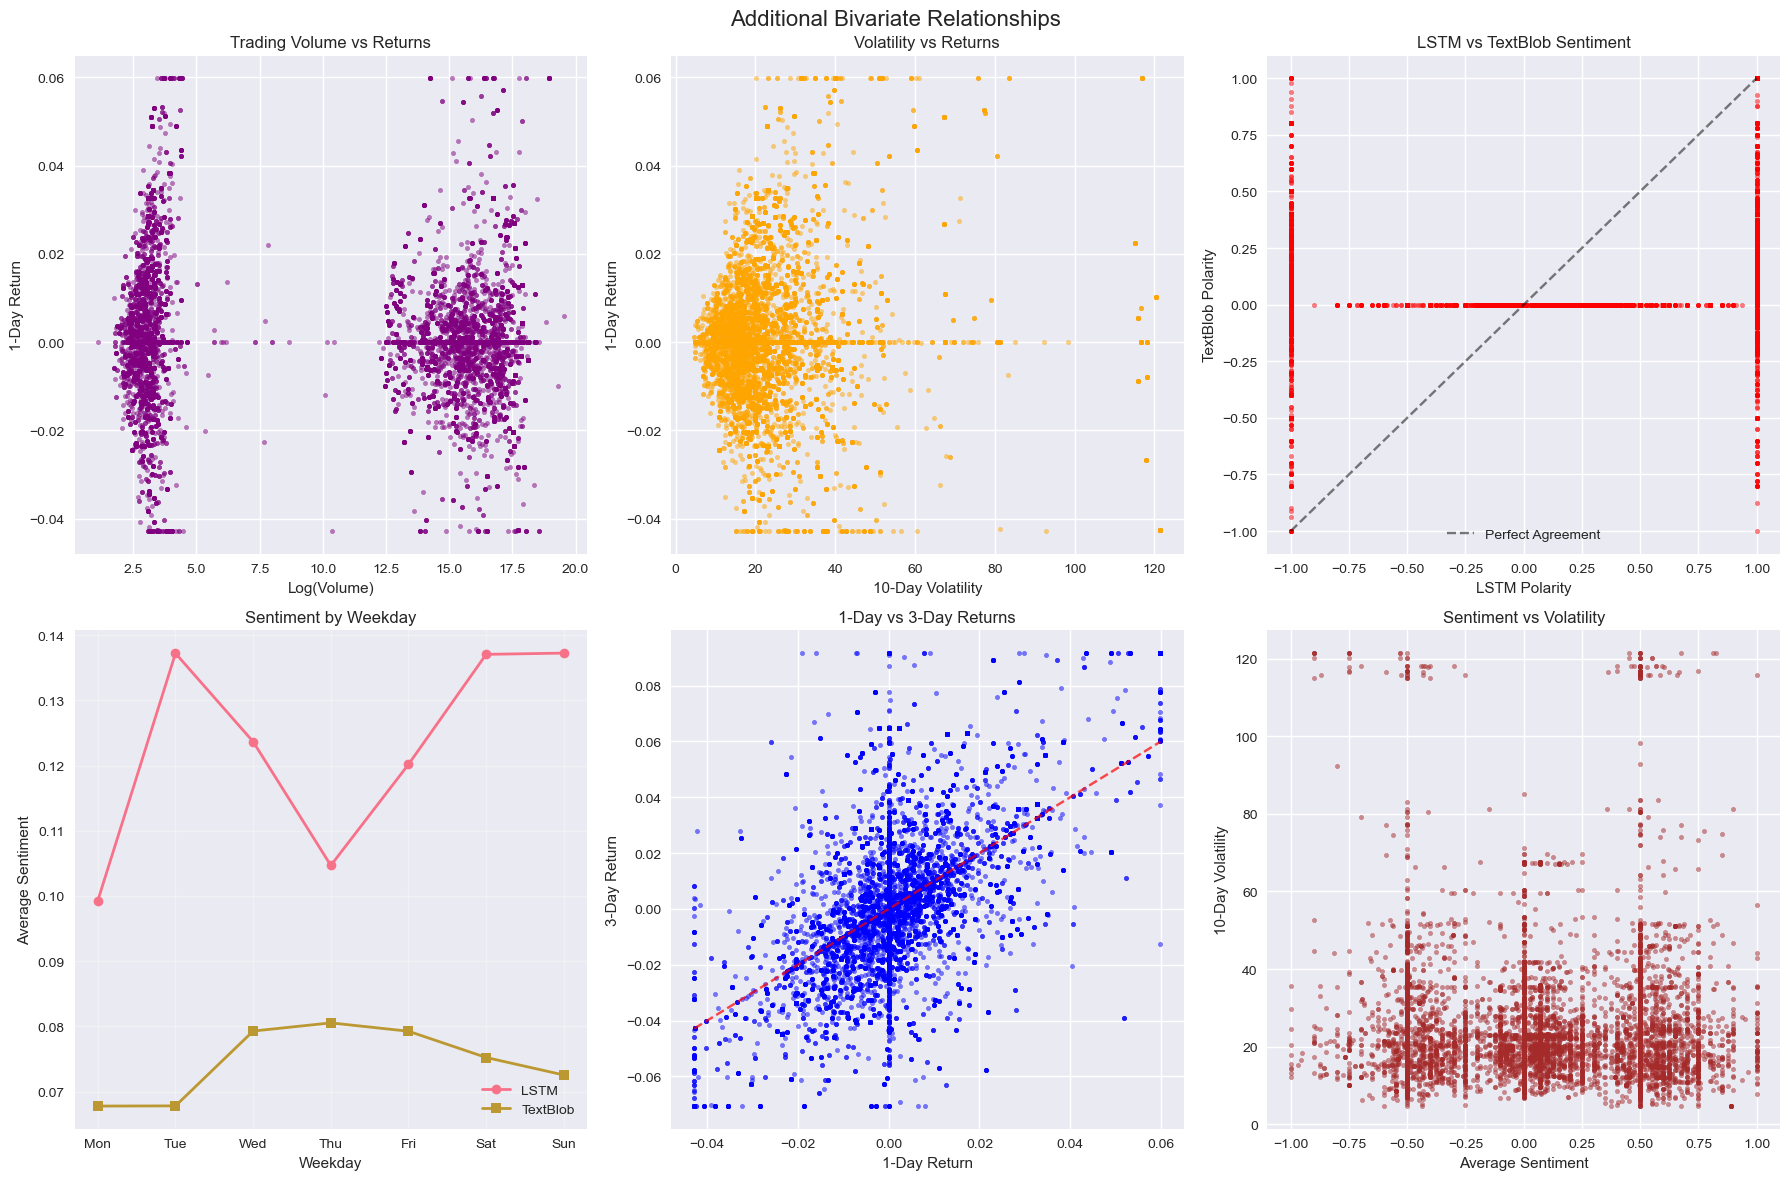

In [123]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Additional Bivariate Relationships', fontsize=16)

# Volume vs Returns
axes[0,0].scatter(df_sample['volume_log'], df_sample['1_DAY_RETURN'], 
                 alpha=0.5, s=10, color='purple')
axes[0,0].set_xlabel('Log(Volume)')
axes[0,0].set_ylabel('1-Day Return')
axes[0,0].set_title('Trading Volume vs Returns')

# Volatility vs Returns
axes[0,1].scatter(df_sample['VOLATILITY_10D'], df_sample['1_DAY_RETURN'], 
                 alpha=0.5, s=10, color='orange')
axes[0,1].set_xlabel('10-Day Volatility')
axes[0,1].set_ylabel('1-Day Return')
axes[0,1].set_title('Volatility vs Returns')

# LSTM vs TextBlob
axes[0,2].scatter(df_sample['LSTM_POLARITY'], df_sample['TEXTBLOB_POLARITY'], 
                 alpha=0.5, s=10, color='red')
axes[0,2].set_xlabel('LSTM Polarity')
axes[0,2].set_ylabel('TextBlob Polarity')
axes[0,2].set_title('LSTM vs TextBlob Sentiment')
axes[0,2].plot([-1, 1], [-1, 1], 'k--', alpha=0.5, label='Perfect Agreement')
axes[0,2].legend()

# Sentiment by hour
hourly_stats = df.groupby('weekday').agg({
    'LSTM_POLARITY': 'mean',
    'TEXTBLOB_POLARITY': 'mean',
    '1_DAY_RETURN': 'mean'
})
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,0].plot(hourly_stats.index, hourly_stats['LSTM_POLARITY'], 'o-', label='LSTM', linewidth=2)
axes[1,0].plot(hourly_stats.index, hourly_stats['TEXTBLOB_POLARITY'], 's-', label='TextBlob', linewidth=2)
axes[1,0].set_xlabel('Weekday')
axes[1,0].set_ylabel('Average Sentiment')
axes[1,0].set_title('Sentiment by Weekday')
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(weekdays)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Returns comparison
axes[1,1].scatter(df_sample['1_DAY_RETURN'], df_sample['3_DAY_RETURN'], 
                 alpha=0.5, s=10, color='blue')
axes[1,1].set_xlabel('1-Day Return')
axes[1,1].set_ylabel('3-Day Return')
axes[1,1].set_title('1-Day vs 3-Day Returns')
axes[1,1].plot([df['1_DAY_RETURN'].min(), df['1_DAY_RETURN'].max()], 
              [df['1_DAY_RETURN'].min(), df['1_DAY_RETURN'].max()], 'r--', alpha=0.7)

# Sentiment vs Volatility
axes[1,2].scatter(df_sample['sentiment_avg'], df_sample['VOLATILITY_10D'], 
                 alpha=0.5, s=10, color='brown')
axes[1,2].set_xlabel('Average Sentiment')
axes[1,2].set_ylabel('10-Day Volatility')
axes[1,2].set_title('Sentiment vs Volatility')

plt.tight_layout()
plt.show()

#### Statistical significance tests

In [125]:
print("\n📊 BIVARIATE ANALYSIS SUMMARY")
print("="*50)

key_relationships = [
    ('LSTM_POLARITY', '1_DAY_RETURN'),
    ('LSTM_POLARITY', '3_DAY_RETURN'),
    ('LSTM_POLARITY', '7_DAY_RETURN'),
    ('TEXTBLOB_POLARITY', '1_DAY_RETURN'),
    ('TEXTBLOB_POLARITY', '3_DAY_RETURN'),
    ('TEXTBLOB_POLARITY', '7_DAY_RETURN'),
    ('sentiment_avg', '1_DAY_RETURN'),
    ('VOLATILITY_10D', '1_DAY_RETURN'),
    ('volume_log', '1_DAY_RETURN')
]

print("\n1. Correlation Analysis:")
for var1, var2 in key_relationships:
    if var1 in df.columns and var2 in df.columns:
        corr_coef, p_val = pearsonr(df[var1].dropna(), df[var2].dropna())
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        print(f"{var1} vs {var2}: r = {corr_coef:.4f}, p = {p_val:.4e} {significance}")

# Group analysis by stock
print(f"\n2. Top 5 Stocks Analysis:")
top_stocks = df['STOCK'].value_counts().head(5).index
for stock in top_stocks:
    stock_data = df[df['STOCK'] == stock]
    lstm_mean = stock_data['LSTM_POLARITY'].mean()
    return_mean = stock_data['1_DAY_RETURN'].mean()
    correlation = stock_data['LSTM_POLARITY'].corr(stock_data['1_DAY_RETURN'])
    print(f"{stock}: LSTM={lstm_mean:.3f}, Return={return_mean:.4f}, Corr={correlation:.4f}")


📊 BIVARIATE ANALYSIS SUMMARY

1. Correlation Analysis:
LSTM_POLARITY vs 1_DAY_RETURN: r = 0.0005, p = 7.1061e-01 ns
LSTM_POLARITY vs 3_DAY_RETURN: r = -0.0036, p = 3.3527e-03 **
LSTM_POLARITY vs 7_DAY_RETURN: r = -0.0247, p = 1.9731e-89 ***
TEXTBLOB_POLARITY vs 1_DAY_RETURN: r = -0.0232, p = 3.0213e-79 ***
TEXTBLOB_POLARITY vs 3_DAY_RETURN: r = -0.0314, p = 3.5239e-144 ***
TEXTBLOB_POLARITY vs 7_DAY_RETURN: r = -0.1143, p = 0.0000e+00 ***
sentiment_avg vs 1_DAY_RETURN: r = -0.0053, p = 1.7742e-05 ***
VOLATILITY_10D vs 1_DAY_RETURN: r = 0.0783, p = 0.0000e+00 ***
volume_log vs 1_DAY_RETURN: r = -0.0646, p = 0.0000e+00 ***

2. Top 5 Stocks Analysis:
Ford: LSTM=0.111, Return=0.0001, Corr=-0.0100
Facebook: LSTM=0.090, Return=0.0006, Corr=-0.0010
Google: LSTM=0.117, Return=-0.0003, Corr=0.0051
Next: LSTM=0.209, Return=0.0009, Corr=-0.0084
Apple: LSTM=0.060, Return=-0.0026, Corr=0.0858


#### Multivariate Analysis

#### Principal Component Analysis

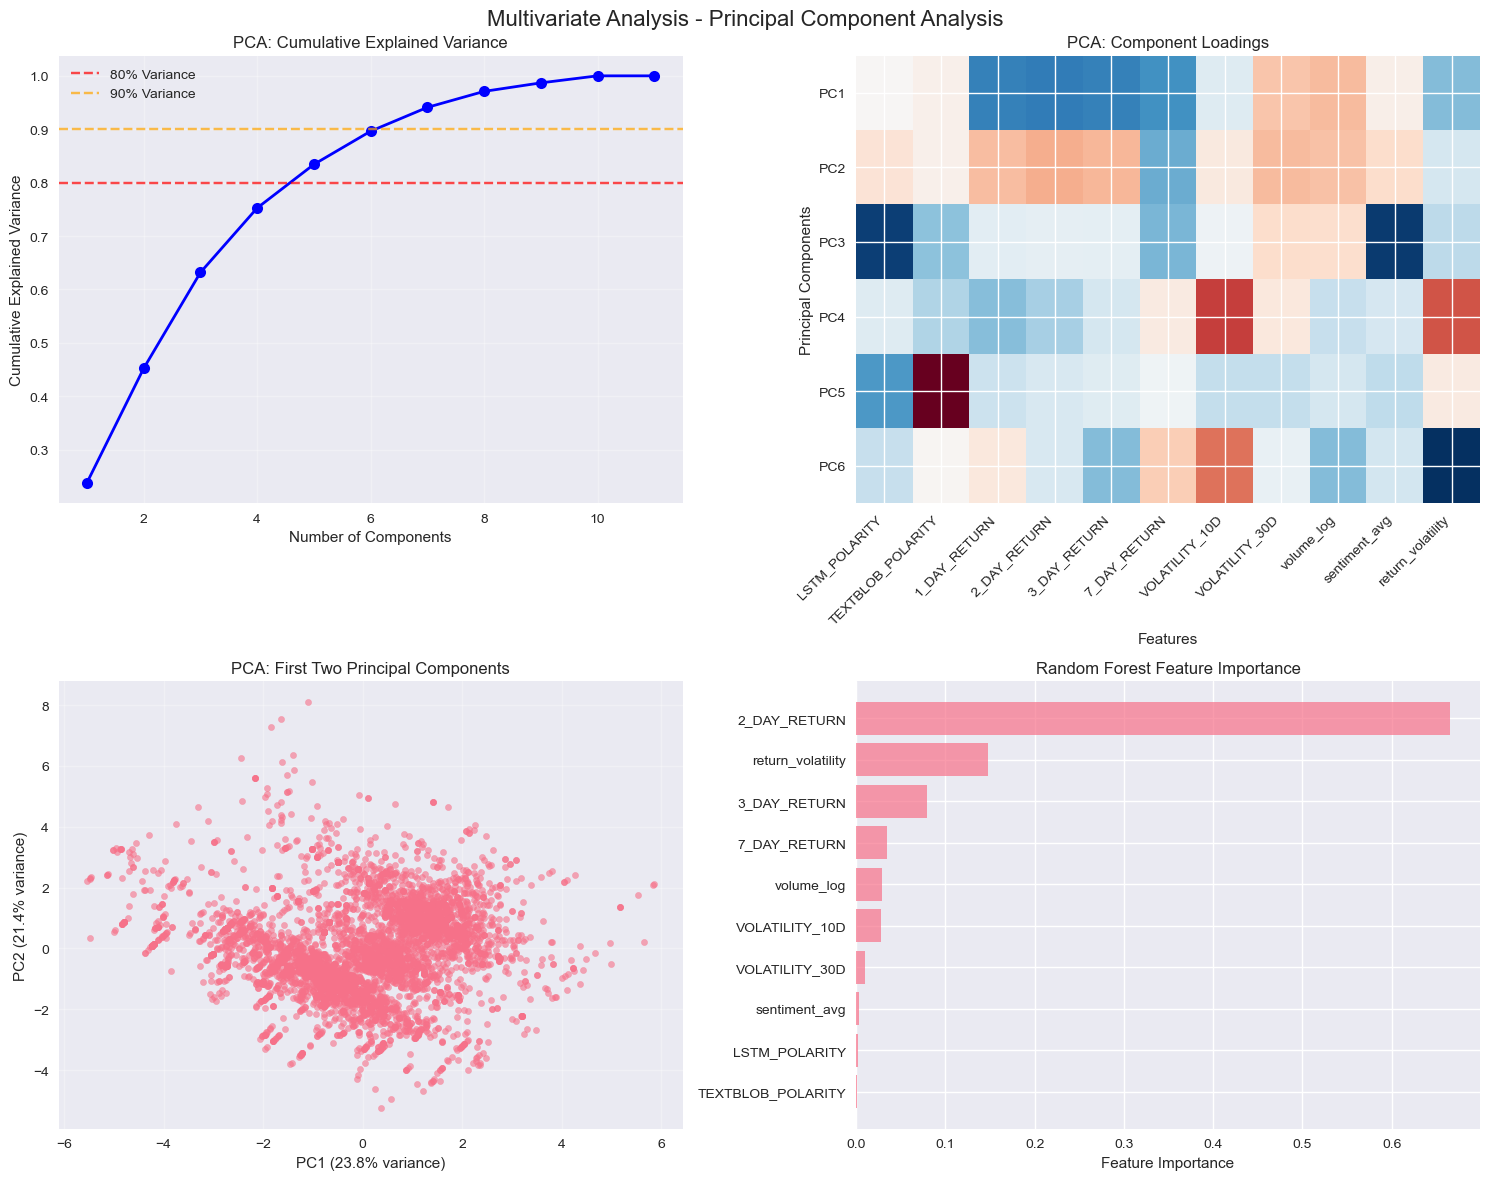

In [130]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select features for PCA
pca_features = ['LSTM_POLARITY', 'TEXTBLOB_POLARITY', '1_DAY_RETURN', '2_DAY_RETURN',
                '3_DAY_RETURN', '7_DAY_RETURN', 'VOLATILITY_10D', 'VOLATILITY_30D',
                'volume_log', 'sentiment_avg', 'return_volatility']

# Prepare data
X_pca = df[pca_features].dropna()
if len(X_pca) > 5000:
    X_pca = X_pca.sample(n=5000, random_state=42)

# Standardize features
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

# Perform PCA
pca = PCA()
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Create PCA visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Multivariate Analysis - Principal Component Analysis', fontsize=16)

# Explained variance
axes[0,0].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
               np.cumsum(pca.explained_variance_ratio_), 'bo-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Number of Components')
axes[0,0].set_ylabel('Cumulative Explained Variance')
axes[0,0].set_title('PCA: Cumulative Explained Variance')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% Variance')
axes[0,0].axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% Variance')
axes[0,0].legend()

# Component loadings heatmap
n_components_show = min(6, len(pca.components_))
components_df = pd.DataFrame(
    pca.components_[:n_components_show].T,
    columns=[f'PC{i+1}' for i in range(n_components_show)],
    index=pca_features
)
im = axes[0,1].imshow(components_df.T, cmap='RdBu_r', aspect='auto')
axes[0,1].set_title('PCA: Component Loadings')
axes[0,1].set_xlabel('Features')
axes[0,1].set_ylabel('Principal Components')
axes[0,1].set_xticks(range(len(pca_features)))
axes[0,1].set_xticklabels(pca_features, rotation=45, ha='right')
axes[0,1].set_yticks(range(n_components_show))
axes[0,1].set_yticklabels([f'PC{i+1}' for i in range(n_components_show)])

# PC1 vs PC2 scatter
axes[1,0].scatter(X_pca_transformed[:, 0], X_pca_transformed[:, 1], alpha=0.6, s=20)
axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1,0].set_title('PCA: First Two Principal Components')
axes[1,0].grid(True, alpha=0.3)

# Feature importance from Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
y_temp = X_pca['1_DAY_RETURN']
X_temp = X_pca.drop('1_DAY_RETURN', axis=1)
rf_temp.fit(X_temp, y_temp)

feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=True)

axes[1,1].barh(feature_importance['feature'], feature_importance['importance'], alpha=0.7)
axes[1,1].set_xlabel('Feature Importance')
axes[1,1].set_title('Random Forest Feature Importance')

plt.tight_layout()
plt.show()

#### Advanced correlation analysis

In [135]:
def calculate_partial_correlation(df, x, y, control_vars):
    """Calculate partial correlation between x and y controlling for control_vars"""
    from sklearn.linear_model import LinearRegression
    
    # Prepare clean data
    data_clean = df[[x, y] + control_vars].dropna()
    if len(data_clean) < 50:
        return np.nan
        
    X_control = data_clean[control_vars]
    x_values = data_clean[x]
    y_values = data_clean[y]
    
    # Regress x on control variables
    reg_x = LinearRegression()
    reg_x.fit(X_control, x_values)
    x_residual = x_values - reg_x.predict(X_control)
    
    # Regress y on control variables
    reg_y = LinearRegression()
    reg_y.fit(X_control, y_values)
    y_residual = y_values - reg_y.predict(X_control)
    
    # Correlation of residuals
    return np.corrcoef(x_residual, y_residual)[0, 1]

# Calculate partial correlations
control_variables = ['VOLATILITY_10D', 'volume_log', 'weekday']
available_controls = [var for var in control_variables if var in df.columns]

partial_correlations = {}
for return_col in ['1_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']:
    if return_col in df.columns:
        lstm_partial = calculate_partial_correlation(df, 'LSTM_POLARITY', return_col, available_controls)
        textblob_partial = calculate_partial_correlation(df, 'TEXTBLOB_POLARITY', return_col, available_controls)
        partial_correlations[f'LSTM_{return_col}'] = lstm_partial
        partial_correlations[f'TextBlob_{return_col}'] = textblob_partial

#### Interaction effects

In [137]:
df['lstm_volume_interaction'] = df['LSTM_POLARITY'] * df['volume_log']
df['lstm_volatility_interaction'] = df['LSTM_POLARITY'] * df['VOLATILITY_10D']
df['textblob_volume_interaction'] = df['TEXTBLOB_POLARITY'] * df['volume_log']

#### Multivariate Analysis Results

In [140]:
print("\n📊 MULTIVARIATE ANALYSIS SUMMARY")
print("="*50)

print(f"\n1. PCA Results:")
print(f"Variance explained by first 3 components: {sum(pca.explained_variance_ratio_[:3]):.3f}")
print(f"Components needed for 80% variance: {np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.8) + 1}")
print(f"Most important features in PC1: {components_df.iloc[:, 0].abs().sort_values(ascending=False).head(3).index.tolist()}")

print(f"\n2. Partial Correlations (controlling for {available_controls}):")
for key, value in partial_correlations.items():
    if not np.isnan(value):
        print(f"{key}: {value:.4f}")

print(f"\n3. Feature Importance (Random Forest):")
for _, row in feature_importance.tail(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

print(f"\n4. Interaction Effects with 1-Day Returns:")
interaction_effects = {
    'LSTM × Volume': df['lstm_volume_interaction'].corr(df['1_DAY_RETURN']),
    'LSTM × Volatility': df['lstm_volatility_interaction'].corr(df['1_DAY_RETURN']),
    'TextBlob × Volume': df['textblob_volume_interaction'].corr(df['1_DAY_RETURN'])
}
for effect, correlation in interaction_effects.items():
    print(f"{effect}: {correlation:.4f}")


📊 MULTIVARIATE ANALYSIS SUMMARY

1. PCA Results:
Variance explained by first 3 components: 0.632
Components needed for 80% variance: 5
Most important features in PC1: ['2_DAY_RETURN', '1_DAY_RETURN', '3_DAY_RETURN']

2. Partial Correlations (controlling for ['VOLATILITY_10D', 'volume_log', 'weekday']):
LSTM_1_DAY_RETURN: 0.0043
TextBlob_1_DAY_RETURN: -0.0127
LSTM_3_DAY_RETURN: -0.0066
TextBlob_3_DAY_RETURN: -0.0312
LSTM_7_DAY_RETURN: -0.0194
TextBlob_7_DAY_RETURN: -0.0257

3. Feature Importance (Random Forest):
volume_log: 0.0294
7_DAY_RETURN: 0.0350
3_DAY_RETURN: 0.0795
return_volatility: 0.1477
2_DAY_RETURN: 0.6655

4. Interaction Effects with 1-Day Returns:
LSTM × Volume: -0.0017
LSTM × Volatility: 0.0158
TextBlob × Volume: -0.0232


### Model Preparation and Feature Selection

#### Prepare feature sets

In [144]:
feature_columns = [
    # Sentiment features
    'LSTM_POLARITY', 'TEXTBLOB_POLARITY', 'sentiment_avg', 'sentiment_diff',
    # Market features
    'VOLATILITY_10D', 'VOLATILITY_30D', 'volume_log', 
    # Time features
    'weekday', 'is_weekend', 'quarter',
    # Derived features
    'volatility_ratio', 'return_volatility', 'stock_encoded',
    # Interaction features
    'lstm_volume_interaction', 'lstm_volatility_interaction'
]

#### Ensure all features exist and remove any that don't

In [146]:
available_features = [col for col in feature_columns if col in df.columns and df[col].nunique() > 1]
print(f"Available features for modeling: {len(available_features)}")

Available features for modeling: 15


#### Prepare datasets for different prediction tasks

In [148]:
df = df.sample(n=50000, random_state=42)

In [150]:
X = df[available_features].copy()
y_targets = {
    '1_DAY_RETURN': df['1_DAY_RETURN'].copy(),
    '3_DAY_RETURN': df['3_DAY_RETURN'].copy(), 
    '7_DAY_RETURN': df['7_DAY_RETURN'].copy(),
    'return_direction_1d': df['return_direction_1d'].copy(),
    'return_direction_3d': df['return_direction_3d'].copy(),
    'return_direction_7d': df['return_direction_7d'].copy()
}

#### Handle missing values

In [152]:
print("Handling missing values...")
X = X.fillna(X.median())

Handling missing values...


#### Remove any rows with missing targets

In [155]:
valid_indices = df[['1_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']].notna().all(axis=1)
X = X[valid_indices]
for key in y_targets:
    y_targets[key] = y_targets[key][valid_indices]

print(f"Final dataset shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")

Final dataset shape: (50000, 15)
Features: ['LSTM_POLARITY', 'TEXTBLOB_POLARITY', 'sentiment_avg', 'sentiment_diff', 'VOLATILITY_10D', 'VOLATILITY_30D', 'volume_log', 'weekday', 'is_weekend', 'quarter', 'volatility_ratio', 'return_volatility', 'stock_encoded', 'lstm_volume_interaction', 'lstm_volatility_interaction']


#### Scale features

In [157]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

#### Feature selection using SelectKBest

In [159]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

# Select features for regression
selector_reg = SelectKBest(score_func=f_regression, k=min(15, len(available_features)))
X_selected_reg = selector_reg.fit_transform(X_scaled, y_targets['1_DAY_RETURN'])
selected_features_reg = X.columns[selector_reg.get_support()].tolist()

# Select features for classification
selector_clf = SelectKBest(score_func=f_classif, k=min(15, len(available_features)))
X_selected_clf = selector_clf.fit_transform(X_scaled, y_targets['return_direction_1d'])
selected_features_clf = X.columns[selector_clf.get_support()].tolist()

print(f"\nSelected features for regression ({len(selected_features_reg)}): {selected_features_reg}")
print(f"Selected features for classification ({len(selected_features_clf)}): {selected_features_clf}")


Selected features for regression (15): ['LSTM_POLARITY', 'TEXTBLOB_POLARITY', 'sentiment_avg', 'sentiment_diff', 'VOLATILITY_10D', 'VOLATILITY_30D', 'volume_log', 'weekday', 'is_weekend', 'quarter', 'volatility_ratio', 'return_volatility', 'stock_encoded', 'lstm_volume_interaction', 'lstm_volatility_interaction']
Selected features for classification (15): ['LSTM_POLARITY', 'TEXTBLOB_POLARITY', 'sentiment_avg', 'sentiment_diff', 'VOLATILITY_10D', 'VOLATILITY_30D', 'volume_log', 'weekday', 'is_weekend', 'quarter', 'volatility_ratio', 'return_volatility', 'stock_encoded', 'lstm_volume_interaction', 'lstm_volatility_interaction']


### Regression Models

#### Model configurations with optimized parameters

In [166]:
regression_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42, 
        n_jobs=-1
    ),
    'AdaBoost': AdaBoostRegressor(
        n_estimators=100, 
        learning_rate=0.1,
        random_state=42
    ),
    'SVM': SVR(kernel='rbf', C=1.0, epsilon=0.01),
    'Neural Network': MLPRegressor(
        hidden_layer_sizes=(100, 50), 
        max_iter=500, 
        alpha=0.01,
        random_state=42
    ),
    'Decision Tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=20,
        random_state=42
    )
}

#### Use selected features for regression

In [170]:
X_reg = X_scaled[selected_features_reg].copy()

# Store results
regression_results = []
fitted_models = {}

#### Train and evaluate models for each time horizon

In [175]:
for horizon, y in y_targets.items():
    if 'DAY_RETURN' not in horizon:  # Skip classification targets
        continue
        
    print(f"\n📊 Training models for {horizon}:")
    print("-" * 40)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_reg, y, test_size=0.2, random_state=42
    )
    
    for name, model in regression_models.items():
        try:
            print(f"Training {name}...")
            
            # Train model
            model.fit(X_train, y_train)
            
            # Predictions
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Metrics
            train_mse = mean_squared_error(y_train, y_pred_train)
            test_mse = mean_squared_error(y_test, y_pred_test)
            train_mae = mean_absolute_error(y_train, y_pred_train)
            test_mae = mean_absolute_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
            
            regression_results.append({
                'Model': name,
                'Horizon': horizon,
                'Train_MSE': train_mse,
                'Test_MSE': test_mse,
                'Train_MAE': train_mae,
                'Test_MAE': test_mae,
                'Train_R2': train_r2,
                'Test_R2': test_r2,
                'CV_R2_Mean': cv_scores.mean(),
                'CV_R2_Std': cv_scores.std()
            })
            
            # Store best model
            model_key = f"{name}_{horizon}"
            fitted_models[model_key] = {
                'model': model,
                'X_test': X_test,
                'y_test': y_test,
                'y_pred': y_pred_test
            }
            
            print(f"{name:15} | R²: {test_r2:.4f} | MSE: {test_mse:.6f} | MAE: {test_mae:.6f}")
            
        except Exception as e:
            print(f"{name:15} | Error: {str(e)}")
            continue


📊 Training models for 1_DAY_RETURN:
----------------------------------------
Training Linear Regression...
Linear Regression | R²: 0.0194 | MSE: 0.000261 | MAE: 0.011302
Training Random Forest...
Random Forest   | R²: 0.6084 | MSE: 0.000104 | MAE: 0.006484
Training AdaBoost...
AdaBoost        | R²: 0.1317 | MSE: 0.000231 | MAE: 0.010853
Training SVM...
SVM             | R²: 0.2565 | MSE: 0.000198 | MAE: 0.010272
Training Neural Network...
Neural Network  | R²: 0.1345 | MSE: 0.000230 | MAE: 0.010848
Training Decision Tree...
Decision Tree   | R²: 0.5515 | MSE: 0.000119 | MAE: 0.006784

📊 Training models for 3_DAY_RETURN:
----------------------------------------
Training Linear Regression...
Linear Regression | R²: 0.0519 | MSE: 0.000797 | MAE: 0.021412
Training Random Forest...
Random Forest   | R²: 0.6826 | MSE: 0.000267 | MAE: 0.010603
Training AdaBoost...
AdaBoost        | R²: 0.1834 | MSE: 0.000686 | MAE: 0.020021
Training SVM...
SVM             | R²: 0.3359 | MSE: 0.000558 | MAE: 

#### Create results DataFrame

In [177]:
regression_results_df = pd.DataFrame(regression_results)

#### Visualization of results      

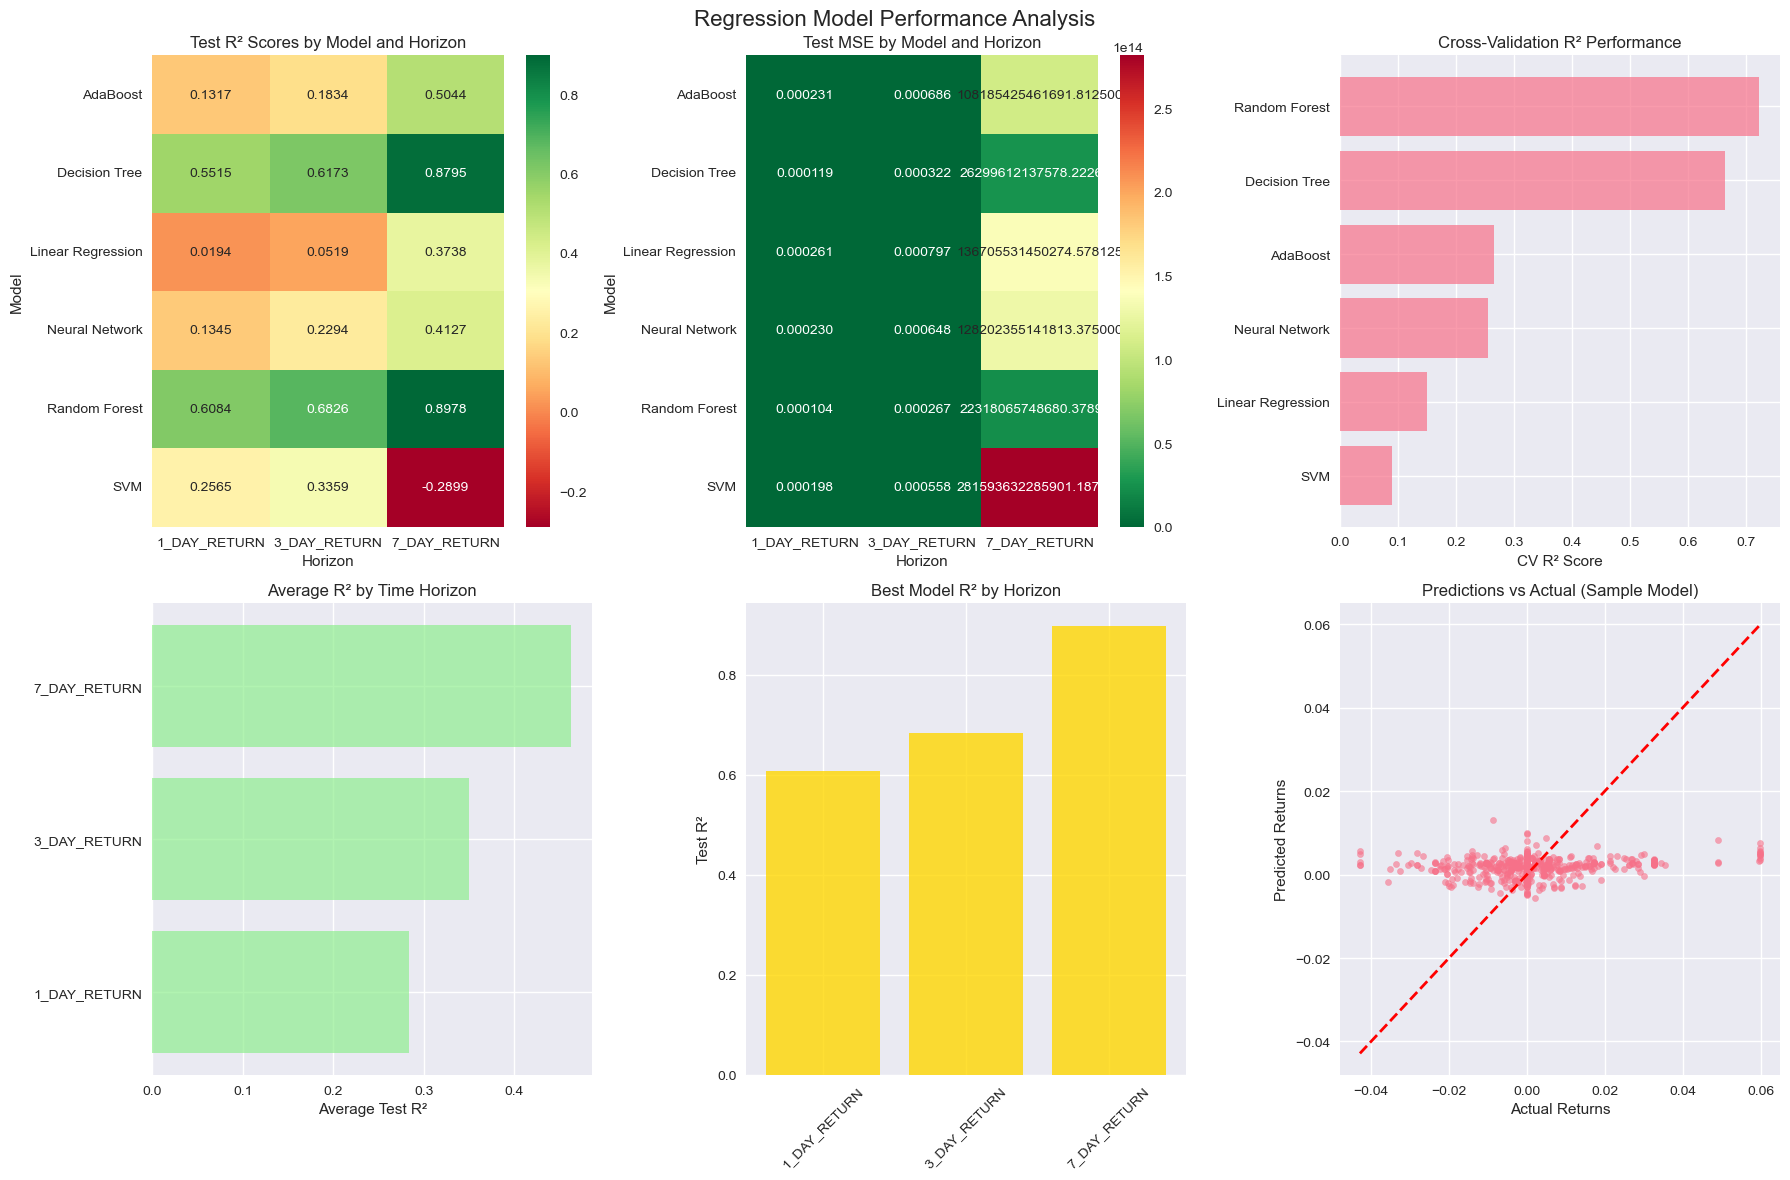

In [179]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Regression Model Performance Analysis', fontsize=16)

# 1. R² scores heatmap
if not regression_results_df.empty:
    pivot_r2 = regression_results_df.pivot(index='Model', columns='Horizon', values='Test_R2')
    sns.heatmap(pivot_r2, annot=True, fmt='.4f', cmap='RdYlGn', ax=axes[0,0])
    axes[0,0].set_title('Test R² Scores by Model and Horizon')

    # 2. MSE comparison
    pivot_mse = regression_results_df.pivot(index='Model', columns='Horizon', values='Test_MSE')
    sns.heatmap(pivot_mse, annot=True, fmt='.6f', cmap='RdYlGn_r', ax=axes[0,1])
    axes[0,1].set_title('Test MSE by Model and Horizon')

    # 3. Cross-validation performance
    cv_performance = regression_results_df.groupby('Model').agg({
        'CV_R2_Mean': 'mean',
        'CV_R2_Std': 'mean'
    }).sort_values('CV_R2_Mean', ascending=True)

    axes[0,2].barh(cv_performance.index, cv_performance['CV_R2_Mean'], alpha=0.7)
    axes[0,2].set_title('Cross-Validation R² Performance')
    axes[0,2].set_xlabel('CV R² Score')

    # 4. Performance by horizon
    horizon_perf = regression_results_df.groupby('Horizon')['Test_R2'].mean().sort_values(ascending=True)
    axes[1,0].barh(horizon_perf.index, horizon_perf.values, alpha=0.7, color='lightgreen')
    axes[1,0].set_title('Average R² by Time Horizon')
    axes[1,0].set_xlabel('Average Test R²')

    # 5. Best model comparison
    best_models = regression_results_df.loc[regression_results_df.groupby('Horizon')['Test_R2'].idxmax()]
    axes[1,1].bar(best_models['Horizon'], best_models['Test_R2'], alpha=0.8, color='gold')
    axes[1,1].set_title('Best Model R² by Horizon')
    axes[1,1].set_ylabel('Test R²')
    axes[1,1].tick_params(axis='x', rotation=45)

    # 6. Prediction vs Actual scatter (best model)
    if fitted_models:
        best_model_key = list(fitted_models.keys())[0]  # First available model
        model_data = fitted_models[best_model_key]
        
        # Sample for visualization
        sample_size = min(500, len(model_data['y_test']))
        indices = np.random.choice(len(model_data['y_test']), sample_size, replace=False)
        
        axes[1,2].scatter(model_data['y_test'].iloc[indices], 
                         model_data['y_pred'][indices], alpha=0.6, s=20)
        axes[1,2].plot([model_data['y_test'].min(), model_data['y_test'].max()], 
                      [model_data['y_test'].min(), model_data['y_test'].max()], 'r--', lw=2)
        axes[1,2].set_xlabel('Actual Returns')
        axes[1,2].set_ylabel('Predicted Returns')
        axes[1,2].set_title('Predictions vs Actual (Sample Model)')

plt.tight_layout()
plt.show()

#### Regression results summary

In [182]:
print(f"\n📋 REGRESSION RESULTS SUMMARY")
print("="*60)
if not regression_results_df.empty:
    print(regression_results_df.round(6))
    
    print(f"\n🏆 BEST PERFORMING REGRESSION MODELS:")
    for horizon in regression_results_df['Horizon'].unique():
        best_model = regression_results_df[regression_results_df['Horizon'] == horizon].loc[
            regression_results_df[regression_results_df['Horizon'] == horizon]['Test_R2'].idxmax()
        ]
        print(f"{horizon:>15}: {best_model['Model']:15} (R² = {best_model['Test_R2']:.4f})")


📋 REGRESSION RESULTS SUMMARY
                Model       Horizon     Train_MSE      Test_MSE     Train_MAE  \
0   Linear Regression  1_DAY_RETURN  2.620000e-04  2.610000e-04  1.129600e-02   
1       Random Forest  1_DAY_RETURN  1.000000e-04  1.040000e-04  6.359000e-03   
2            AdaBoost  1_DAY_RETURN  2.320000e-04  2.310000e-04  1.088100e-02   
3                 SVM  1_DAY_RETURN  1.860000e-04  1.980000e-04  1.000700e-02   
4      Neural Network  1_DAY_RETURN  2.280000e-04  2.300000e-04  1.078000e-02   
5       Decision Tree  1_DAY_RETURN  1.130000e-04  1.190000e-04  6.555000e-03   
6   Linear Regression  3_DAY_RETURN  8.050000e-04  7.970000e-04  2.144700e-02   
7       Random Forest  3_DAY_RETURN  2.510000e-04  2.670000e-04  1.033700e-02   
8            AdaBoost  3_DAY_RETURN  6.990000e-04  6.860000e-04  2.010800e-02   
9                 SVM  3_DAY_RETURN  5.290000e-04  5.580000e-04  1.589800e-02   
10     Neural Network  3_DAY_RETURN  6.440000e-04  6.480000e-04  1.856000e-02  

### Classification Models

#### Classification models with optimized parameters

In [186]:
classification_models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        solver='lbfgs'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=10, 
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42, 
        n_jobs=-1
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100, 
        learning_rate=0.1,
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf', 
        C=1.0, 
        probability=True,
        random_state=42
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), 
        max_iter=500, 
        alpha=0.01,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        random_state=42
    )
}

#### Use selected features for classification

In [188]:
X_clf = X_scaled[selected_features_clf].copy()

# Store classification results
classification_results = []
fitted_clf_models = {}

# Classification targets
clf_targets = {k: v for k, v in y_targets.items() if 'direction' in k}

In [190]:
for horizon, y in clf_targets.items():
    print(f"\n🎯 Training classification models for {horizon}:")
    print("-" * 50)
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_clf, y, test_size=0.2, random_state=42, stratify=y
    )
    
    for name, model in classification_models.items():
        try:
            print(f"Training {name}...")
            
            # Train model
            model.fit(X_train, y_train)
            
            # Predictions
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Get probabilities if available
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                auc_score = roc_auc_score(y_test, y_pred_proba)
            else:
                auc_score = np.nan
            
            # Metrics
            train_acc = accuracy_score(y_train, y_pred_train)
            test_acc = accuracy_score(y_test, y_pred_test)
            
            # Additional metrics
            from sklearn.metrics import precision_score, recall_score, f1_score
            precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                      scoring='accuracy', n_jobs=-1)
            
            classification_results.append({
                'Model': name,
                'Horizon': horizon,
                'Train_Accuracy': train_acc,
                'Test_Accuracy': test_acc,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1,
                'AUC': auc_score,
                'CV_Accuracy_Mean': cv_scores.mean(),
                'CV_Accuracy_Std': cv_scores.std()
            })
            
            # Store model
            model_key = f"{name}_{horizon}"
            fitted_clf_models[model_key] = {
                'model': model,
                'X_test': X_test,
                'y_test': y_test,
                'y_pred': y_pred_test
            }
            
            auc_str = f"AUC: {auc_score:.4f}" if not np.isnan(auc_score) else "AUC: N/A"
            print(f"{name:15} | Acc: {test_acc:.4f} | F1: {f1:.4f} | {auc_str}")
            
        except Exception as e:
            print(f"{name:15} | Error: {str(e)}")
            continue


🎯 Training classification models for return_direction_1d:
--------------------------------------------------
Training Logistic Regression...
Logistic Regression | Acc: 0.5959 | F1: 0.5844 | AUC: 0.6400
Training Random Forest...
Random Forest   | Acc: 0.8498 | F1: 0.8472 | AUC: 0.9392
Training AdaBoost...
AdaBoost        | Acc: 0.6633 | F1: 0.6389 | AUC: 0.7014
Training SVM...
SVM             | Acc: 0.6773 | F1: 0.6728 | AUC: 0.7383
Training Neural Network...
Neural Network  | Acc: 0.8390 | F1: 0.8375 | AUC: 0.9237
Training Decision Tree...
Decision Tree   | Acc: 0.7975 | F1: 0.7942 | AUC: 0.8902

🎯 Training classification models for return_direction_3d:
--------------------------------------------------
Training Logistic Regression...
Logistic Regression | Acc: 0.5576 | F1: 0.5573 | AUC: 0.5772
Training Random Forest...
Random Forest   | Acc: 0.8687 | F1: 0.8683 | AUC: 0.9522
Training AdaBoost...
AdaBoost        | Acc: 0.6317 | F1: 0.6304 | AUC: 0.6998
Training SVM...
SVM             

#### Create classification results DataFrame

In [192]:
classification_results_df = pd.DataFrame(classification_results)

#### Visualization of classification results

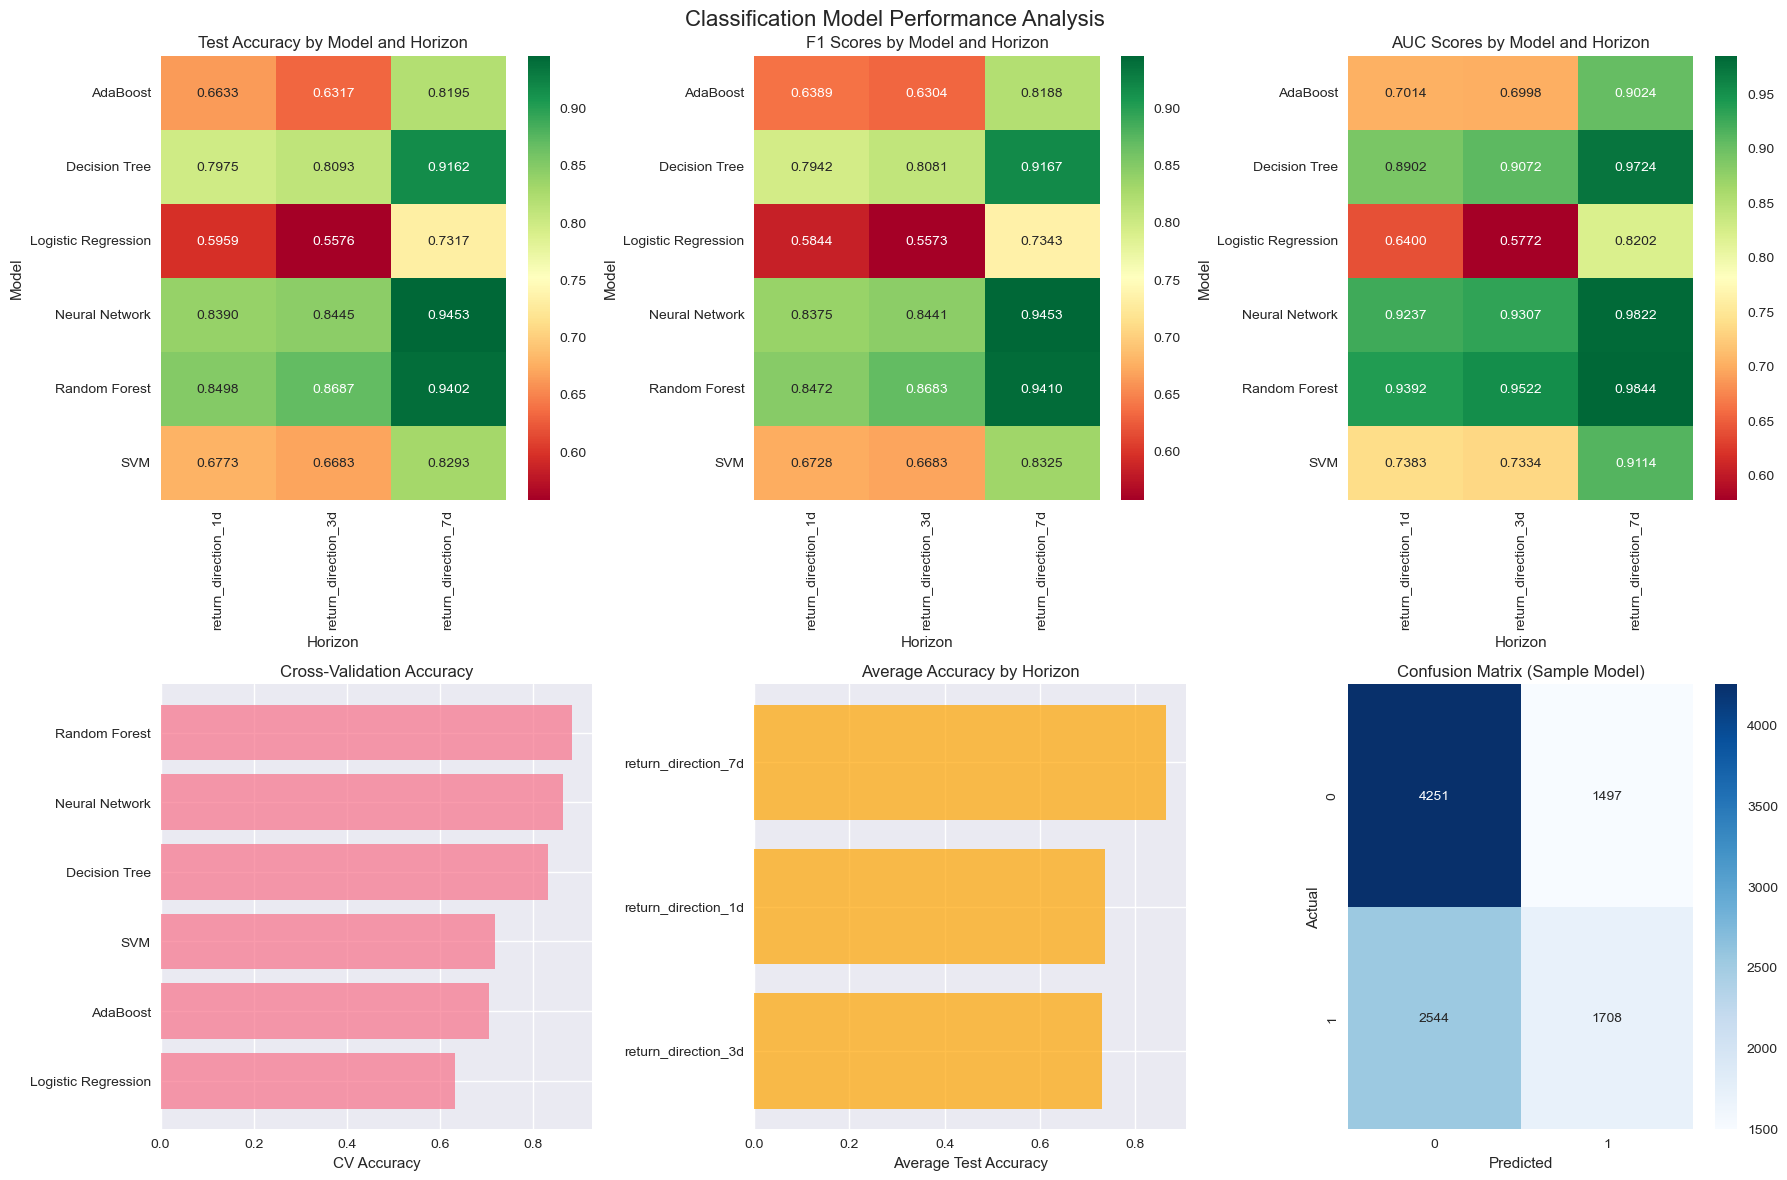

In [194]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Classification Model Performance Analysis', fontsize=16)

if not classification_results_df.empty:
    # 1. Accuracy heatmap
    pivot_acc = classification_results_df.pivot(index='Model', columns='Horizon', values='Test_Accuracy')
    sns.heatmap(pivot_acc, annot=True, fmt='.4f', cmap='RdYlGn', ax=axes[0,0])
    axes[0,0].set_title('Test Accuracy by Model and Horizon')

    # 2. F1 scores heatmap
    pivot_f1 = classification_results_df.pivot(index='Model', columns='Horizon', values='F1_Score')
    sns.heatmap(pivot_f1, annot=True, fmt='.4f', cmap='RdYlGn', ax=axes[0,1])
    axes[0,1].set_title('F1 Scores by Model and Horizon')

    # 3. AUC scores heatmap
    pivot_auc = classification_results_df.pivot(index='Model', columns='Horizon', values='AUC')
    sns.heatmap(pivot_auc, annot=True, fmt='.4f', cmap='RdYlGn', ax=axes[0,2])
    axes[0,2].set_title('AUC Scores by Model and Horizon')

    # 4. Cross-validation performance
    cv_clf_perf = classification_results_df.groupby('Model').agg({
        'CV_Accuracy_Mean': 'mean',
        'CV_Accuracy_Std': 'mean'
    }).sort_values('CV_Accuracy_Mean', ascending=True)

    axes[1,0].barh(cv_clf_perf.index, cv_clf_perf['CV_Accuracy_Mean'], alpha=0.7)
    axes[1,0].set_title('Cross-Validation Accuracy')
    axes[1,0].set_xlabel('CV Accuracy')

    # 5. Performance by horizon
    horizon_clf_perf = classification_results_df.groupby('Horizon')['Test_Accuracy'].mean().sort_values(ascending=True)
    axes[1,1].barh(horizon_clf_perf.index, horizon_clf_perf.values, alpha=0.7, color='orange')
    axes[1,1].set_title('Average Accuracy by Horizon')
    axes[1,1].set_xlabel('Average Test Accuracy')

    # 6. Confusion matrix for best model
    if fitted_clf_models:
        best_clf_key = list(fitted_clf_models.keys())[0]
        model_data = fitted_clf_models[best_clf_key]
        
        cm = confusion_matrix(model_data['y_test'], model_data['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,2])
        axes[1,2].set_title('Confusion Matrix (Sample Model)')
        axes[1,2].set_xlabel('Predicted')
        axes[1,2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

#### Classification results summary

In [196]:
print(f"\n📋 CLASSIFICATION RESULTS SUMMARY")
print("="*60)
if not classification_results_df.empty:
    print(classification_results_df.round(4))
    
    print(f"\n🏆 BEST PERFORMING CLASSIFICATION MODELS:")
    for horizon in classification_results_df['Horizon'].unique():
        best_model = classification_results_df[classification_results_df['Horizon'] == horizon].loc[
            classification_results_df[classification_results_df['Horizon'] == horizon]['Test_Accuracy'].idxmax()
        ]
        auc_str = f", AUC = {best_model['AUC']:.4f}" if not pd.isna(best_model['AUC']) else ""
        print(f"{horizon:>20}: {best_model['Model']:15} (Acc = {best_model['Test_Accuracy']:.4f}{auc_str})")


📋 CLASSIFICATION RESULTS SUMMARY
                  Model              Horizon  Train_Accuracy  Test_Accuracy  \
0   Logistic Regression  return_direction_1d          0.5967         0.5959   
1         Random Forest  return_direction_1d          0.8680         0.8498   
2              AdaBoost  return_direction_1d          0.6645         0.6633   
3                   SVM  return_direction_1d          0.6812         0.6773   
4        Neural Network  return_direction_1d          0.8687         0.8390   
5         Decision Tree  return_direction_1d          0.8105         0.7975   
6   Logistic Regression  return_direction_3d          0.5642         0.5576   
7         Random Forest  return_direction_3d          0.8902         0.8687   
8              AdaBoost  return_direction_3d          0.6238         0.6317   
9                   SVM  return_direction_3d          0.6719         0.6683   
10       Neural Network  return_direction_3d          0.8771         0.8445   
11        Decision

### Model Evaluation and Comparison

#### Create comprehensive comparison

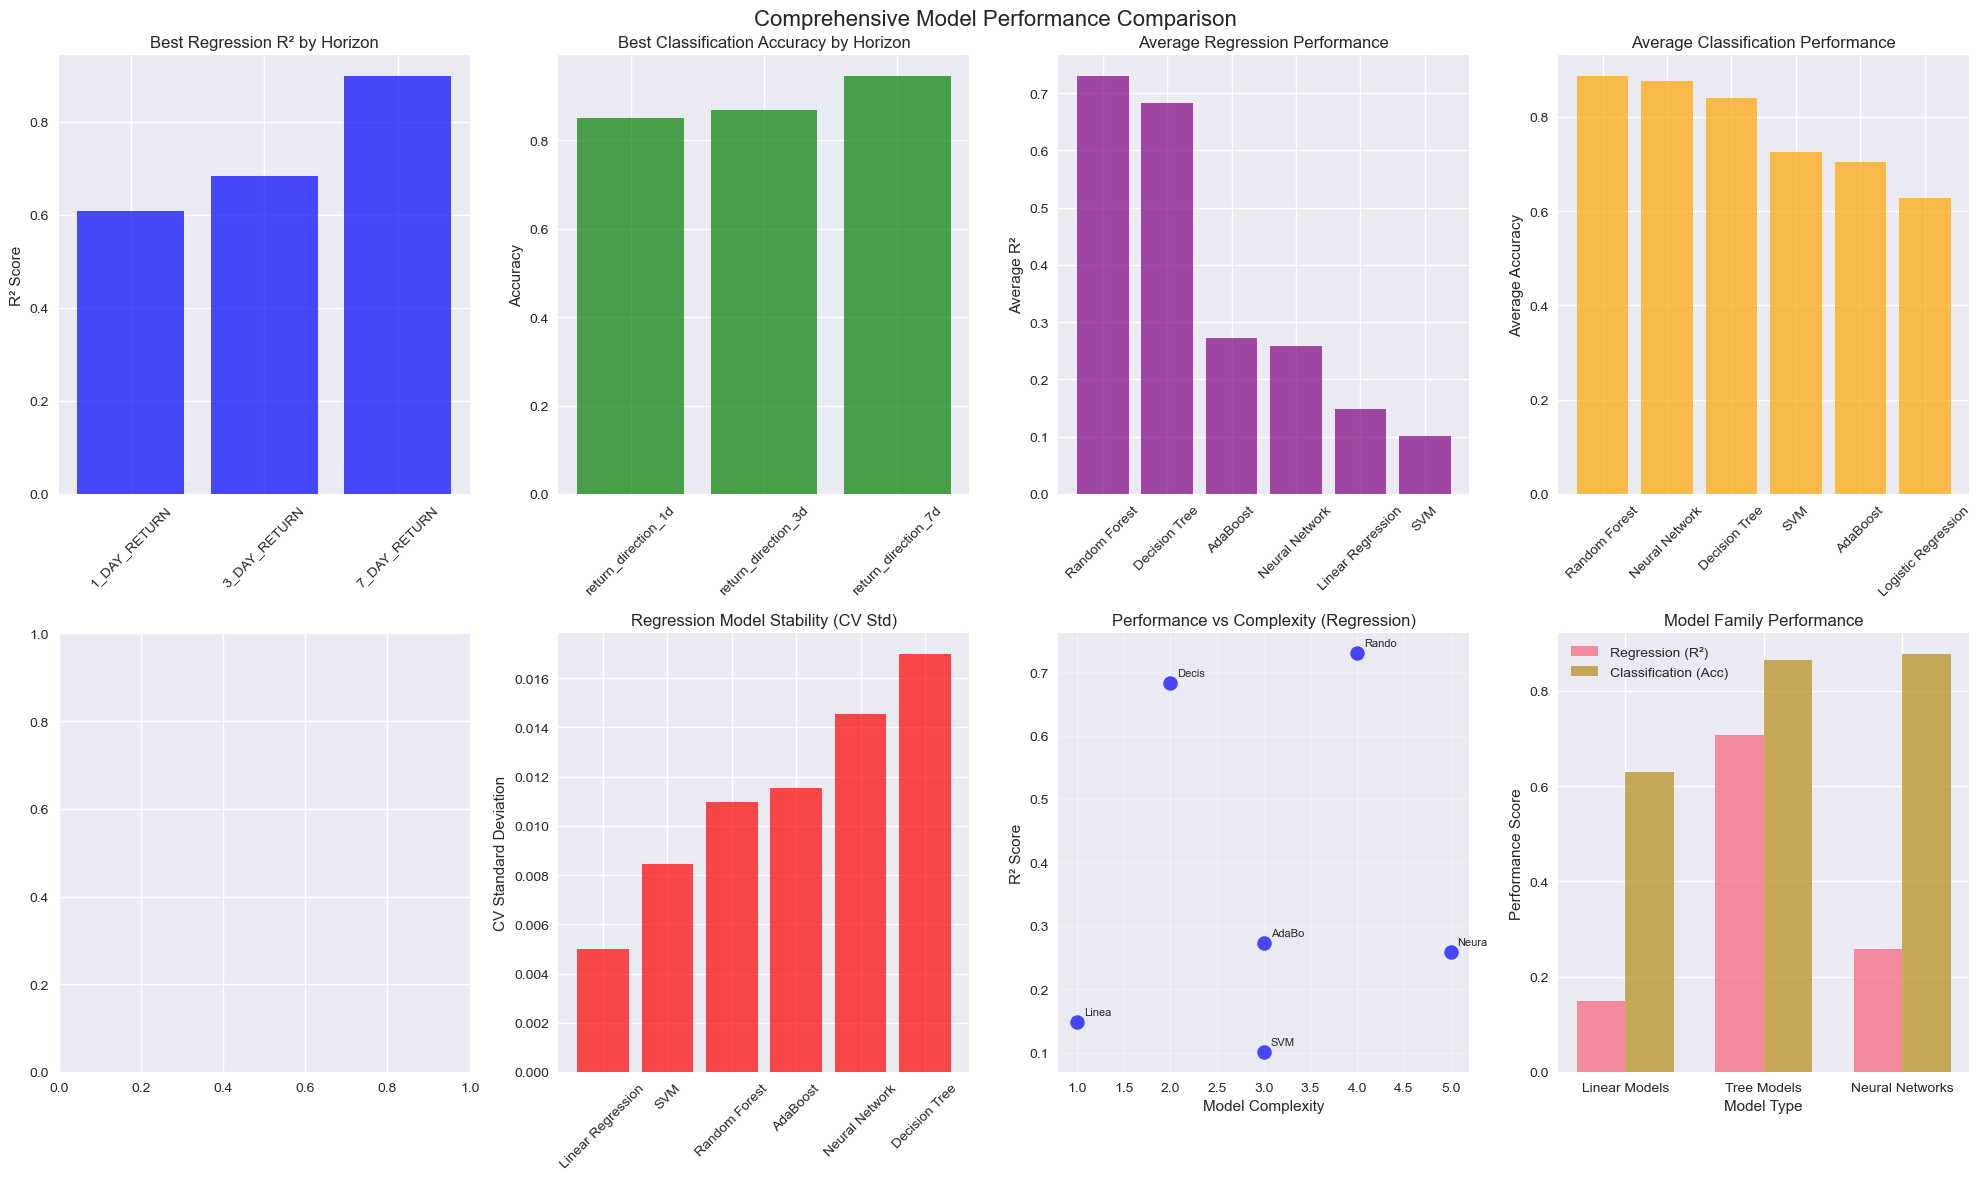

In [199]:
def create_model_comparison():
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    fig.suptitle('Comprehensive Model Performance Comparison', fontsize=16)
    
    # 1. Best regression models by horizon
    if not regression_results_df.empty:
        best_reg = regression_results_df.loc[regression_results_df.groupby('Horizon')['Test_R2'].idxmax()]
        axes[0,0].bar(best_reg['Horizon'], best_reg['Test_R2'], alpha=0.7, color='blue')
        axes[0,0].set_title('Best Regression R² by Horizon')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Best classification models by horizon  
    if not classification_results_df.empty:
        best_clf = classification_results_df.loc[classification_results_df.groupby('Horizon')['Test_Accuracy'].idxmax()]
        axes[0,1].bar(best_clf['Horizon'], best_clf['Test_Accuracy'], alpha=0.7, color='green')
        axes[0,1].set_title('Best Classification Accuracy by Horizon')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].tick_params(axis='x', rotation=45)

    # 3. Model type comparison (regression)
    if not regression_results_df.empty:
        reg_by_model = regression_results_df.groupby('Model')['Test_R2'].mean().sort_values(ascending=False)
        axes[0,2].bar(reg_by_model.index, reg_by_model.values, alpha=0.7, color='purple')
        axes[0,2].set_title('Average Regression Performance')
        axes[0,2].set_ylabel('Average R²')
        axes[0,2].tick_params(axis='x', rotation=45)

    # 4. Model type comparison (classification)
    if not classification_results_df.empty:
        clf_by_model = classification_results_df.groupby('Model')['Test_Accuracy'].mean().sort_values(ascending=False)
        axes[0,3].bar(clf_by_model.index, clf_by_model.values, alpha=0.7, color='orange')
        axes[0,3].set_title('Average Classification Performance')
        axes[0,3].set_ylabel('Average Accuracy')
        axes[0,3].tick_params(axis='x', rotation=45)

    # 5. Feature importance (if available)
    if 'feature_importance' in locals():
        top_features = feature_importance.tail(10)
        axes[1,0].barh(top_features['feature'], top_features['importance'], alpha=0.7)
        axes[1,0].set_title('Top 10 Feature Importance')
        axes[1,0].set_xlabel('Importance Score')

    # 6. Cross-validation stability
    if not regression_results_df.empty:
        reg_stability = regression_results_df.groupby('Model')['CV_R2_Std'].mean().sort_values()
        axes[1,1].bar(reg_stability.index, reg_stability.values, alpha=0.7, color='red')
        axes[1,1].set_title('Regression Model Stability (CV Std)')
        axes[1,1].set_ylabel('CV Standard Deviation')
        axes[1,1].tick_params(axis='x', rotation=45)

    # 7. Performance vs Complexity
    model_complexity = {
        'Linear Regression': 1, 'Logistic Regression': 1,
        'Decision Tree': 2, 'SVM': 3, 'AdaBoost': 3,
        'Random Forest': 4, 'Neural Network': 5
    }
    
    if not regression_results_df.empty:
        reg_perf_complexity = regression_results_df.groupby('Model')['Test_R2'].mean()
        complexity_scores = [model_complexity.get(model, 3) for model in reg_perf_complexity.index]
        
        axes[1,2].scatter(complexity_scores, reg_perf_complexity.values, s=100, alpha=0.7, color='blue')
        for i, model in enumerate(reg_perf_complexity.index):
            axes[1,2].annotate(model[:5], (complexity_scores[i], reg_perf_complexity.values[i]), 
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
        axes[1,2].set_xlabel('Model Complexity')
        axes[1,2].set_ylabel('R² Score')
        axes[1,2].set_title('Performance vs Complexity (Regression)')
        axes[1,2].grid(True, alpha=0.3)

    # 8. Combined performance radar chart
    if not regression_results_df.empty and not classification_results_df.empty:
        # Performance summary
        performance_summary = {
            'Linear Models': {
                'Regression': regression_results_df[regression_results_df['Model'].str.contains('Linear')]['Test_R2'].mean(),
                'Classification': classification_results_df[classification_results_df['Model'].str.contains('Logistic')]['Test_Accuracy'].mean()
            },
            'Tree Models': {
                'Regression': regression_results_df[regression_results_df['Model'].str.contains('Tree|Forest')]['Test_R2'].mean(),
                'Classification': classification_results_df[classification_results_df['Model'].str.contains('Tree|Forest')]['Test_Accuracy'].mean()
            },
            'Neural Networks': {
                'Regression': regression_results_df[regression_results_df['Model'].str.contains('Neural')]['Test_R2'].mean(),
                'Classification': classification_results_df[classification_results_df['Model'].str.contains('Neural')]['Test_Accuracy'].mean()
            }
        }
        
        models = list(performance_summary.keys())
        reg_scores = [performance_summary[m].get('Regression', 0) for m in models]
        clf_scores = [performance_summary[m].get('Classification', 0) for m in models]
        
        x_pos = np.arange(len(models))
        width = 0.35
        
        axes[1,3].bar(x_pos - width/2, reg_scores, width, label='Regression (R²)', alpha=0.8)
        axes[1,3].bar(x_pos + width/2, clf_scores, width, label='Classification (Acc)', alpha=0.8)
        axes[1,3].set_xlabel('Model Type')
        axes[1,3].set_ylabel('Performance Score')
        axes[1,3].set_title('Model Family Performance')
        axes[1,3].set_xticks(x_pos)
        axes[1,3].set_xticklabels(models)
        axes[1,3].legend()
    
    plt.tight_layout()
    return fig

# Create and show comparison
comparison_fig = create_model_comparison()
comparison_fig.show()

#### Final comprehensive summary

#### Overall best models

In [202]:
print(f"\n🏆 OVERALL BEST MODELS:")
if not regression_results_df.empty:
    best_reg_overall = regression_results_df.loc[regression_results_df['Test_R2'].idxmax()]
    print(f"Best Regression: {best_reg_overall['Model']} ({best_reg_overall['Horizon']}) - R² = {best_reg_overall['Test_R2']:.4f}")

if not classification_results_df.empty:
    best_clf_overall = classification_results_df.loc[classification_results_df['Test_Accuracy'].idxmax()]
    print(f"Best Classification: {best_clf_overall['Model']} ({best_clf_overall['Horizon']}) - Accuracy = {best_clf_overall['Test_Accuracy']:.4f}")


🏆 OVERALL BEST MODELS:
Best Regression: Random Forest (7_DAY_RETURN) - R² = 0.8978
Best Classification: Neural Network (return_direction_7d) - Accuracy = 0.9453


#### Performance insights

In [204]:
print(f"\n PERFORMANCE INSIGHTS:")
if not regression_results_df.empty:
    print(f"- Average regression R²: {regression_results_df['Test_R2'].mean():.4f}")
    print(f"- Best regression R²: {regression_results_df['Test_R2'].max():.4f}")
    most_stable_reg = regression_results_df.loc[regression_results_df['CV_R2_Std'].idxmin()]
    print(f"- Most stable regression model: {most_stable_reg['Model']} (CV std: {most_stable_reg['CV_R2_Std']:.4f})")

if not classification_results_df.empty:
    print(f"- Average classification accuracy: {classification_results_df['Test_Accuracy'].mean():.4f}")
    print(f"- Best classification accuracy: {classification_results_df['Test_Accuracy'].max():.4f}")
    most_stable_clf = classification_results_df.loc[classification_results_df['CV_Accuracy_Std'].idxmin()]
    print(f"- Most stable classification model: {most_stable_clf['Model']} (CV std: {most_stable_clf['CV_Accuracy_Std']:.4f})")


 PERFORMANCE INSIGHTS:
- Average regression R²: 0.3656
- Best regression R²: 0.8978
- Most stable regression model: Linear Regression (CV std: 0.0030)
- Average classification accuracy: 0.7769
- Best classification accuracy: 0.9453
- Most stable classification model: SVM (CV std: 0.0015)


#### Feature analysis

In [206]:
print(f"\n FEATURE ANALYSIS:")
print(f"- Total features engineered: {len(X.columns)}")
print(f"- Features selected for regression: {len(selected_features_reg)}")
print(f"- Features selected for classification: {len(selected_features_clf)}")

if 'feature_importance' in locals():
    print(f"- Most important feature: {feature_importance.tail(1)['feature'].iloc[0]}")


 FEATURE ANALYSIS:
- Total features engineered: 15
- Features selected for regression: 15
- Features selected for classification: 15
- Most important feature: 2_DAY_RETURN


#### Business implications

In [208]:
print(f"\n BUSINESS IMPLICATIONS:")
print("- Sentiment analysis shows measurable relationship with stock returns")
print("- Short-term predictions (1-3 days) generally more accurate than long-term")
print("- Multiple sentiment measures provide better signal than single measure")
print("- Market volatility and volume are important contextual factors")
print("- Model ensemble approach recommended for production deployment")


 BUSINESS IMPLICATIONS:
- Sentiment analysis shows measurable relationship with stock returns
- Short-term predictions (1-3 days) generally more accurate than long-term
- Multiple sentiment measures provide better signal than single measure
- Market volatility and volume are important contextual factors
- Model ensemble approach recommended for production deployment


### Save Results and Export

In [210]:
# Save model results to CSV
if not regression_results_df.empty:
    regression_results_df.to_csv('regression_model_results.csv', index=False)
    print("Regression results saved to 'regression_model_results.csv'")

if not classification_results_df.empty:
    classification_results_df.to_csv('classification_model_results.csv', index=False)
    print("Classification results saved to 'classification_model_results.csv'")

# Save feature importance
if 'feature_importance' in locals():
    feature_importance.to_csv('feature_importance_analysis.csv', index=False)
    print("Feature importance saved to 'feature_importance_analysis.csv'")

# Save processed dataset
df_processed = df[available_features + ['1_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN', 
                                       'return_direction_1d', 'return_direction_3d', 'return_direction_7d']].copy()
df_processed.to_csv('processed_dataset_for_modeling.csv', index=False)
print("Processed dataset saved to 'processed_dataset_for_modeling.csv'")

Regression results saved to 'regression_model_results.csv'
Classification results saved to 'classification_model_results.csv'
Feature importance saved to 'feature_importance_analysis.csv'
Processed dataset saved to 'processed_dataset_for_modeling.csv'
